In [1]:
# !pip install optbinning
# !pip install scorecardpy
# !pip install seaborn

In [2]:
from datetime import datetime
from matplotlib import pyplot
from optbinning import OptimalBinning, ContinuousOptimalBinning, Scorecard, BinningProcess
from optbinning.scorecard.plots import plot_ks, plot_auc_roc
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,plot_confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scorecardpy as sc
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Utility functions

In [3]:
def df_summarier(df) -> pd.DataFrame:
    a = df.isna().any(axis=0)
    notnan= df.count()
    b = df.dtypes
    c = df.nunique()
    d = pd.Series({col: df[col].unique() for col in df})
    print("df.shape", df.shape)
    # print("df.created_time.min()", df.created_time.min(), "df.created_time.max()", df.created_time.max(), )
    print("df summary")
    return pd.concat([a, notnan,b, c,d,df.describe().T], axis=1).rename(
        columns={0: "has nan?",1: "num of notnan", 2: "dtypes", 3: "num of unique values", 4: "list of unique values"}
    )


def create_binning_config(df_: pd.DataFrame, force_monotonic: bool =False) -> dict:
    bfp={}
    for col in df_.columns:
        if col=='TARGET':
            continue
        dtype="numerical"
        solver="cp"
        if df_[col].dtype==object:
            dtype="categorical"
            # solver="mip"
        name=col
        
        if force_monotonic:
            bfp[name]= {"dtype": dtype, "solver": solver, "monotonic_trend":'auto_asc_desc'}
        else:
            bfp[name]= {"dtype": dtype, "solver": solver}

            

    return bfp


def predictiveness(i: float) -> str:
    if i <0.02: return 'Not useful for prediction'
    if 0.02 < i <= 0.1: return 'Weak predictive Power'
    if 0.1  < i <= 0.3: return 'Medium predictive Power'
    if 0.3  < i <= 0.5: return 'Strong predictive Power'
    if i >0.5: return 'Suspicious Predictive Power'


def create_binning(df_: pd.DataFrame, binning_fit_params: dict, special_codes=[999999,365243], plot=True) -> BinningProcess:
    # 1) Define list of features and categorical ones
    list_features = df_.drop(columns=['TARGET']).columns.values
    list_categorical = df_.select_dtypes(include=['object', 'category']).columns.values
    # 2) Instantiate BinningProcess
    binning_process = BinningProcess(
        categorical_variables=list_categorical,
        variable_names=list_features, binning_fit_params=binning_fit_params,
        special_codes=special_codes
    )

    # 3) Fit and transform dataset
    binning_process.fit(df_.drop(columns=['TARGET']), df_.TARGET)


    for col in binning_process.variable_names:
        optb=binning_process.get_binned_variable(col)
        optb.binning_table.build()
        if plot:
            print(col)
            optb.binning_table.plot(metric="woe")
            display(optb.binning_table.build())
            display(optb.binning_table.build().Bin.values.tolist())

            print('==')


    return binning_process


def get_iv(binning_process: BinningProcess) -> pd.DataFrame:
    ll=[]

    for col in binning_process.variable_names:
        optb=binning_process.get_binned_variable(col)
        # optb.binning_table.plot(metric="woe")
        iv=optb.binning_table.build().IV.Totals
        ll.append({"column": col, "IV":iv})

    dfiv=pd.DataFrame(ll).sort_values('IV', ascending=False)
    dfiv['predictiveness']=dfiv.IV.apply(predictiveness)
    return dfiv

def get_class_weight(df_):
    cw0full=df_.groupby('TARGET').count().T.iloc[0]
    class_weightfull=(1-(cw0full/df.shape[0])).to_dict()
    return class_weightfull

# Load Data

In [4]:
df = pd.read_csv('app_train.csv')
dftest = pd.read_csv('app_test.csv')
dfprev = pd.read_csv('prev_app.csv')
dfinst = pd.read_csv('installment_payment.csv')
dfdesc = pd.read_csv('columns_description.csv')

In [7]:
dfinst=dfinst.sort_values(['LN_ID', 'SK_ID_PREV', 'INST_NUMBER'])

In [11]:
dfinst['overdue_days']= (dfinst.INST_DAYS - dfinst.PAY_DAYS).fillna(99999)
dfinst['has_overdue_day']= np.where(dfinst['overdue_days']>0,1,0)

dfinst['overdue_amt']= dfinst.AMT_INST - dfinst.AMT_PAY.fillna(0)
dfinst['has_overdue_amt']= np.where(dfinst['overdue_amt']>0,1,0)

In [12]:
dfinst

,Unnamed: 0,SK_ID_PREV,LN_ID,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,overdue_days,has_overdue_day,overdue_amt,has_overdue_amt
454639,2652500,1112703,100009,1,-1531.0,-1542.0,9845.010,9845.010,11.0,1,0.0,0
253462,1478784,1112703,100009,2,-1501.0,-1508.0,9845.010,9845.010,7.0,1,0.0,0
144096,841148,1112703,100009,3,-1471.0,-1475.0,9845.010,9845.010,4.0,1,0.0,0
474641,2768093,1112703,100009,4,-1441.0,-1445.0,9845.010,9845.010,4.0,1,0.0,0
223761,1304738,1112703,100009,5,-1411.0,-1416.0,9845.010,9845.010,5.0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2177794,12816277,2631384,456255,23,-96.0,-98.0,27489.690,27489.690,2.0,1,0.0,0
2067724,12164846,2631384,456255,24,-66.0,-76.0,308277.315,308277.315,10.0,1,0.0,0
2090527,12300604,2729207,456255,1,-469.0,-482.0,11514.555,11514.555,13.0,1,0.0,0
2135733,12567314,2729207,456255,2,-439.0,-455.0,11514.555,11514.555,16.0,1,0.0,0


In [5]:
df.shape, dfprev.shape, dfinst.shape

((61503, 24), (350712, 19), (2872306, 8))

In [6]:
dfprev.head().T

,0,1,2,3,4
Unnamed: 0,0,3,5,6,10
SK_ID_PREV,2030495,2819243,1383531,2315218,1715995
LN_ID,271877,176158,199383,175704,447712
CONTRACT_TYPE,Consumer loans,Cash loans,Cash loans,Cash loans,Cash loans
ANNUITY,1730.43,47041.335,23703.93,NaN,11368.62
APPLICATION,17145.0,450000.0,315000.0,0.0,270000.0
APPROVED_CREDIT,17145.0,470790.0,340573.5,0.0,335754.0
AMT_DOWN_PAYMENT,0.0,NaN,NaN,NaN,NaN
PRICE,17145.0,450000.0,315000.0,NaN,270000.0
WEEKDAYS_APPLY,SATURDAY,MONDAY,SATURDAY,TUESDAY,FRIDAY


In [7]:
dfinst.head().T

,0,1,2,3,4
Unnamed: 0,5.000,8.00,11.00,17.00,18.0
SK_ID_PREV,1137312.000,2723183.00,2558880.00,1410565.00,2391610.0
LN_ID,164489.000,112102.00,154793.00,197687.00,183431.0
INST_NUMBER,12.000,14.00,8.00,1.00,20.0
INST_DAYS,-1384.000,-197.00,-1262.00,-1037.00,-1680.0
PAY_DAYS,-1417.000,-197.00,-1269.00,-1048.00,-1693.0
AMT_INST,5970.375,70.74,15031.08,12514.05,7875.0
AMT_PAY,5970.375,70.74,15031.08,12510.45,7875.0


In [8]:
df.shape, dfprev.shape, dfinst.shape

((61503, 24), (350712, 19), (2872306, 8))

# EDA

## Summary

In [9]:
df_summarier(df)

df.shape (61503, 24)
df summary


,has nan?,num of notnan,dtypes,num of unique values,list of unique values,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,False,61503,int64,61503,"[201468, 264803, 137208, 269220, 122096, 16956...",61503.0,153729.986927,88881.478853,6.000000e+00,76545.500000,153893.000000,230884.500000,3.075100e+05
LN_ID,False,61503,int64,61503,"[333538, 406644, 259130, 411997, 241559, 29653...",61503.0,278151.136416,102918.206671,1.000090e+05,188767.000000,278357.000000,367424.500000,4.562550e+05
TARGET,False,61503,int64,2,"[0, 1]",61503.0,0.080793,0.272519,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CONTRACT_TYPE,False,61503,object,2,"[Revolving loans, Cash loans]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GENDER,False,61503,object,2,"[F, M]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUM_CHILDREN,False,61503,int64,10,"[1, 0, 2, 3, 4, 6, 5, 8, 7, 9]",61503.0,0.411850,0.716686,0.000000e+00,0.000000,0.000000,1.000000,9.000000e+00
INCOME,False,61503,float64,861,"[67500.0, 202500.0, 180000.0, 225000.0, 135000...",61503.0,169078.871801,133969.661046,2.610000e+04,112500.000000,148500.000000,202500.000000,1.800009e+07
APPROVED_CREDIT,False,61503,float64,3562,"[202500.0, 976711.5, 407520.0, 808650.0, 18000...",61503.0,597689.917175,401649.345170,4.500000e+04,270000.000000,512446.500000,808650.000000,4.050000e+06
ANNUITY,True,61502,float64,9374,"[10125.0, 49869.0, 25060.5, 26086.5, 9000.0, 3...",61502.0,27083.323315,14470.508291,2.164500e+03,16506.000000,24853.500000,34596.000000,2.580255e+05
PRICE,True,61441,float64,541,"[202500.0, 873000.0, 360000.0, 675000.0, 18000...",61441.0,536903.319811,368574.224006,4.500000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06


## Correlation plot

<AxesSubplot:>

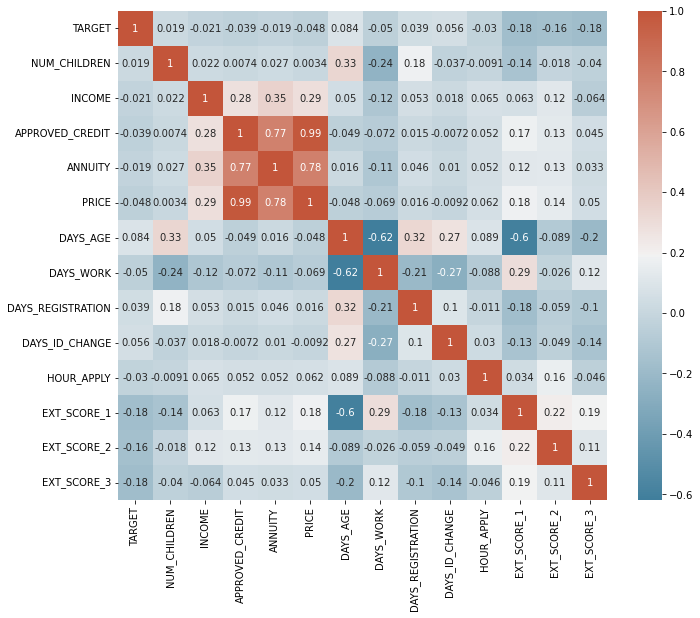

In [10]:
import seaborn as sns
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.drop(['Unnamed: 0', 'LN_ID'],axis=1).corr(), annot=True,square=True,cmap=cmap)

because Approved_Credit, annuity, and price are very correlated, we will just use approved_credit because it has no missing_values

In [11]:
## Boxplot

In [12]:
# KDE plot

# for col in df.select_dtypes(exclude= 'object' ):
#     plt.figure()
#     sns.kdeplot(df[col], hue = df.TARGET)

## Histogram

array([[<AxesSubplot:title={'center':'TARGET'}>,
        <AxesSubplot:title={'center':'NUM_CHILDREN'}>,
        <AxesSubplot:title={'center':'INCOME'}>,
        <AxesSubplot:title={'center':'APPROVED_CREDIT'}>],
       [<AxesSubplot:title={'center':'ANNUITY'}>,
        <AxesSubplot:title={'center':'PRICE'}>,
        <AxesSubplot:title={'center':'DAYS_AGE'}>,
        <AxesSubplot:title={'center':'DAYS_WORK'}>],
       [<AxesSubplot:title={'center':'DAYS_REGISTRATION'}>,
        <AxesSubplot:title={'center':'DAYS_ID_CHANGE'}>,
        <AxesSubplot:title={'center':'HOUR_APPLY'}>,
        <AxesSubplot:title={'center':'EXT_SCORE_1'}>],
       [<AxesSubplot:title={'center':'EXT_SCORE_2'}>,
        <AxesSubplot:title={'center':'EXT_SCORE_3'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

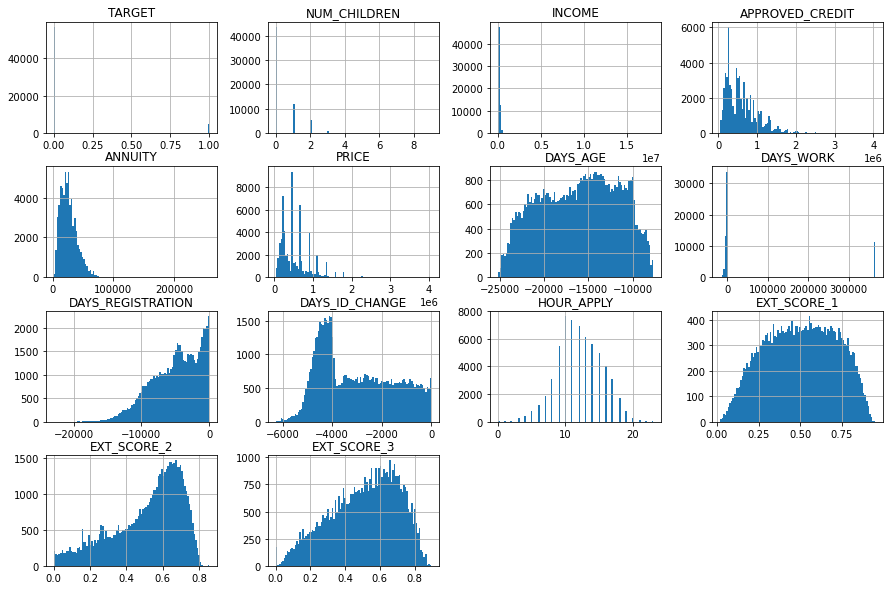

In [13]:
df.drop(['Unnamed: 0', 'LN_ID'],axis=1).hist(bins=100, figsize=(15, 10))

In [14]:
df.DAYS_WORK.max()

365243

<AxesSubplot:>

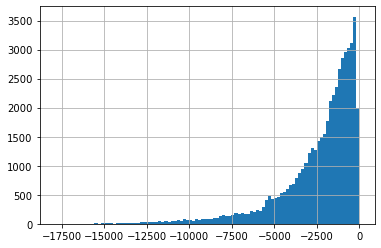

In [15]:
df.DAYS_WORK[df.DAYS_WORK<365243].hist(bins=100)

We see there is an anomaly in DAYS_WORK, we will flag this value on binning

In [16]:
print(dftest.DAYS_WORK[dftest.DAYS_WORK>0].nunique())
dftest.DAYS_WORK[dftest.DAYS_WORK>0].head()

1


7     365243
8     365243
10    365243
24    365243
26    365243
Name: DAYS_WORK, dtype: int64

In [17]:
# aa=(df[['EXT_SCORE_1','DAYS_AGE']].abs() / df[['EXT_SCORE_1','DAYS_AGE']].abs().max()).sort_values('EXT_SCORE_1').reset_index().drop('index',axis=1)

In [18]:
# aa

We will also flag value=365243 on test dataset

In [19]:
# import seaborn as sns
# f, ax = plt.subplots(figsize=(15, 15))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# sns.heatmap(dflebar.drop(['PRICE','ANNUITY','Canceled'],axis=1).corr(), annot=True,square=True,cmap=cmap)


In [20]:
# sns.pairplot(dflebar[['EXT_SCORE_1','DAYS_AGE','TARGET']], hue="TARGET")

# Generate dataset. Join with dfprev & dfinst

In [21]:
def generate_dataset(
    df_, dfprev, dfinst,
    drop_cols=['LN_ID','Unnamed: 0', 'SK_ID_PREV', 'HOUR_APPLY','WEEKDAYS_APPLY','PRICE','ANNUITY','Canceled'],
    special_max=  999999,
    special_min= -999999
) -> pd.DataFrame:
    df_['terms_payment'] = (df_.APPROVED_CREDIT/df_.ANNUITY)
    df_['terms_payment'].round().hist()

    insure_rate= (
        dfprev[dfprev.CONTRACT_STATUS=='Approved'].groupby('LN_ID').NFLAG_INSURED_ON_APPROVAL.sum()
        /
        dfprev[dfprev.CONTRACT_STATUS=='Approved'].groupby('LN_ID').NFLAG_INSURED_ON_APPROVAL.count()

    )
    df_['credit_per_income']=(df.APPROVED_CREDIT/df.INCOME)
    
    contract_status_count = dfprev.groupby(['LN_ID', 'CONTRACT_STATUS']).CONTRACT_STATUS.count()#.reset_index().set_index('LN_ID')
    contract_status_count.head()
    contract_status_rate = contract_status_count/ dfprev.groupby(['LN_ID']).CONTRACT_STATUS.count()
    contract_status_rate.head()
    contract_status_rate_unstack=contract_status_rate.unstack(level=1).fillna(0)
    
    dfinst['overdue_days']= (dfinst.INST_DAYS - dfinst.PAY_DAYS).fillna(special_max)
    dfinst['has_overdue_day']= np.where(dfinst['overdue_days']>0,1,0)

    dfinst['overdue_amt']= dfinst.AMT_INST - dfinst.AMT_PAY.fillna(0)
    dfinst['has_overdue_amt']= np.where(dfinst['overdue_amt']>0,1,0)

    dfinstmini = dfinst[['LN_ID','SK_ID_PREV','overdue_days','overdue_amt','has_overdue_day','has_overdue_amt']]
    
    dflebar=pd.merge(df_,contract_status_rate_unstack.fillna(0), on='LN_ID',how='left')

    dflebar=pd.merge(df_,contract_status_rate_unstack.fillna(0), on='LN_ID',how='left')

    dflebar=pd.merge(dflebar,dfinstmini.groupby('LN_ID').sum(),on=['LN_ID'], how='left',suffixes=('', '_y'))
    
    dflebar=dflebar.set_index('LN_ID')
    dflebar['insure_rate'] = insure_rate
    dflebar=dflebar.reset_index()
    
    dflebar['year_age']= -(dflebar['DAYS_AGE']/365)
    dflebar['year_work']= -(dflebar['DAYS_WORK']/365)
    
    dflebar=dflebar.drop(['DAYS_AGE', 'DAYS_WORK'],axis=1,errors='ignore')


    
    dflebar=dflebar.drop(drop_cols,axis=1,errors='ignore')

    return dflebar

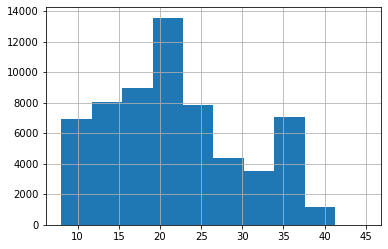

In [22]:
dflebar=generate_dataset(df, dfprev, dfinst)

In [23]:
# dflebar

# train validation split

We will split train * validation split equally

In [24]:
train, valid = sc.split_df(dflebar, 'TARGET').values()

In [25]:
print("train")
display(train.groupby('TARGET').count().CONTRACT_TYPE)
print("valid")
display(valid.groupby('TARGET').count().CONTRACT_TYPE)

train


TARGET
0    39574
1     3478
Name: CONTRACT_TYPE, dtype: int64

valid


TARGET
0    16960
1     1491
Name: CONTRACT_TYPE, dtype: int64

# WOE Binning

## exploratory on non-monotonic binning

In [26]:
create_binning_config?

Signature:
create_binning_config(
    df_: pandas.core.frame.DataFrame,
    force_monotonic: bool = False,
) -> dict
Docstring: <no docstring>
File:      c:\users\mrlut\appdata\local\temp\ipykernel_14952\1635124060.py
Type:      function


In [27]:
bfp=create_binning_config(train)
bfp

{'CONTRACT_TYPE': {'dtype': 'categorical', 'solver': 'cp'},
 'GENDER': {'dtype': 'categorical', 'solver': 'cp'},
 'NUM_CHILDREN': {'dtype': 'numerical', 'solver': 'cp'},
 'INCOME': {'dtype': 'numerical', 'solver': 'cp'},
 'APPROVED_CREDIT': {'dtype': 'numerical', 'solver': 'cp'},
 'INCOME_TYPE': {'dtype': 'categorical', 'solver': 'cp'},
 'EDUCATION': {'dtype': 'categorical', 'solver': 'cp'},
 'FAMILY_STATUS': {'dtype': 'categorical', 'solver': 'cp'},
 'HOUSING_TYPE': {'dtype': 'categorical', 'solver': 'cp'},
 'DAYS_REGISTRATION': {'dtype': 'numerical', 'solver': 'cp'},
 'DAYS_ID_CHANGE': {'dtype': 'numerical', 'solver': 'cp'},
 'ORGANIZATION_TYPE': {'dtype': 'categorical', 'solver': 'cp'},
 'EXT_SCORE_1': {'dtype': 'numerical', 'solver': 'cp'},
 'EXT_SCORE_2': {'dtype': 'numerical', 'solver': 'cp'},
 'EXT_SCORE_3': {'dtype': 'numerical', 'solver': 'cp'},
 'terms_payment': {'dtype': 'numerical', 'solver': 'cp'},
 'credit_per_income': {'dtype': 'numerical', 'solver': 'cp'},
 'Approved': 

In [28]:
train

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,...,Approved,Refused,Unused offer,overdue_days,overdue_amt,has_overdue_day,has_overdue_amt,insure_rate,year_age,year_work
2,0,Cash loans,F,0,180000.0,407520.0,Pensioner,Secondary / secondary special,Married,House / apartment,...,0.666667,0.166667,0.000000,145.0,0.00,27.0,0.0,0.5,56.917808,-1000.665753
4,0,Revolving loans,M,0,135000.0,180000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0.833333,0.166667,0.000000,166.0,25020.72,19.0,6.0,0.4,24.693151,3.260274
6,0,Cash loans,F,0,90000.0,71109.0,Working,Secondary / secondary special,Married,Municipal apartment,...,0.307692,0.307692,0.076923,261.0,85519.26,26.0,12.0,0.5,53.197260,4.580822
7,0,Cash loans,F,0,112500.0,562500.0,State servant,Higher education,Married,House / apartment,...,0.750000,0.000000,0.000000,442.0,0.00,48.0,0.0,0.6,45.947945,3.671233
8,0,Cash loans,F,1,112500.0,360000.0,Working,Secondary / secondary special,Married,House / apartment,...,0.125000,0.375000,0.000000,312.0,0.00,20.0,0.0,0.0,26.747945,2.167123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61495,1,Cash loans,M,2,157500.0,123993.0,Working,Secondary / secondary special,Single / not married,Rented apartment,...,0.750000,0.250000,0.000000,356.0,10948.41,22.0,2.0,0.0,34.246575,2.663014
61497,0,Cash loans,F,2,58500.0,148365.0,Working,Secondary / secondary special,Married,House / apartment,...,0.666667,0.000000,0.000000,125.0,0.00,7.0,0.0,0.5,35.487671,5.249315
61498,0,Cash loans,M,2,360000.0,450000.0,State servant,Secondary / secondary special,Married,House / apartment,...,0.285714,0.714286,0.000000,431.0,0.00,37.0,0.0,0.0,39.090411,15.926027
61500,0,Revolving loans,F,0,202500.0,900000.0,Commercial associate,Higher education,Married,House / apartment,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.572603,4.284932


<AxesSubplot:>

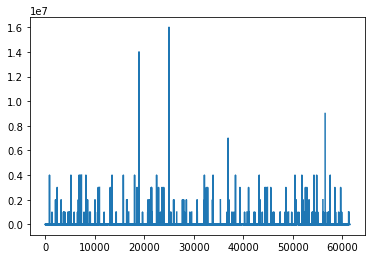

In [29]:
train.overdue_days.plot()

<AxesSubplot:xlabel='INCOME'>

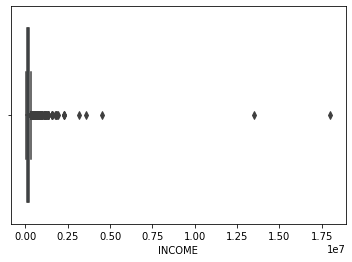

In [30]:
sns.boxplot(data=df,x=df["INCOME"])

<AxesSubplot:xlabel='INCOME', ylabel='Density'>

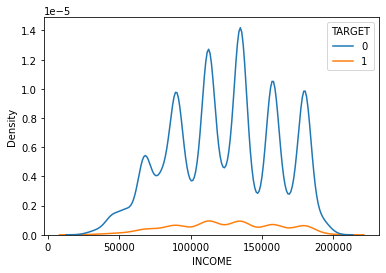

In [31]:
sns.kdeplot(x=df.INCOME[df.INCOME<2.025000e+05], hue=df.TARGET[df.INCOME<2.025000e+05])

<AxesSubplot:>

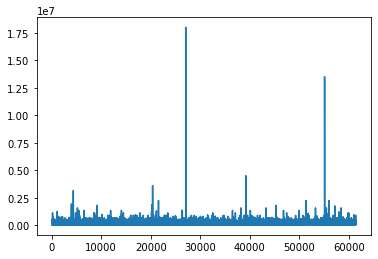

In [32]:
df.INCOME.plot()

In [33]:
df.DAYS_AGE/365

0       -31.613699
1       -43.131507
2       -56.917808
3       -56.600000
4       -24.693151
           ...    
61498   -39.090411
61499   -59.128767
61500   -48.572603
61501   -30.843836
61502   -67.408219
Name: DAYS_AGE, Length: 61503, dtype: float64

Regardless of monotonicity, we want to know the predictive power of each feature

CONTRACT_TYPE


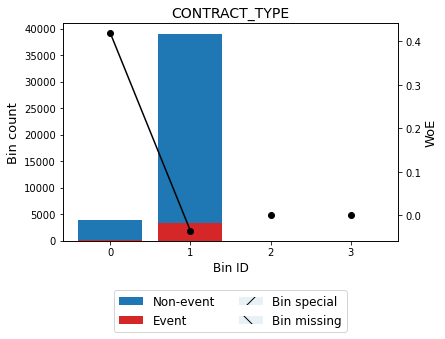

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Revolving loans],3988,0.092632,3770,218,0.054664,0.41862,0.013641,0.001693
1,[Cash loans],39064,0.907368,35804,3260,0.083453,-0.035382,0.001153,0.000144
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.014794,0.001837


[array(['Revolving loans'], dtype=object),
 array(['Cash loans'], dtype=object),
 'Special',
 'Missing',
 '']

==
GENDER


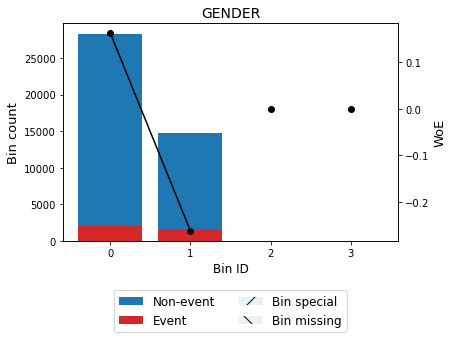

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[F],28336,0.658181,26366,1970,0.069523,0.162327,0.016205,0.002023
1,[M],14716,0.341819,13208,1508,0.102473,-0.261676,0.026123,0.003256
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.042327,0.005279


[array(['F'], dtype=object),
 array(['M'], dtype=object),
 'Special',
 'Missing',
 '']

==
NUM_CHILDREN


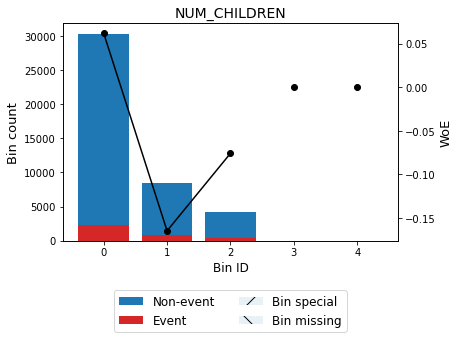

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",30313,0.704102,28000,2313,0.076304,0.061944,0.002632,0.000329
1,"[0.50, 1.50)",8478,0.196925,7682,796,0.093890,-0.164679,0.005723,0.000715
2,"[1.50, inf)",4261,0.098973,3892,369,0.086599,-0.075833,0.000588,0.000073
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.008943,0.001117


['(-inf, 0.50)', '[0.50, 1.50)', '[1.50, inf)', 'Special', 'Missing', '']

==
INCOME


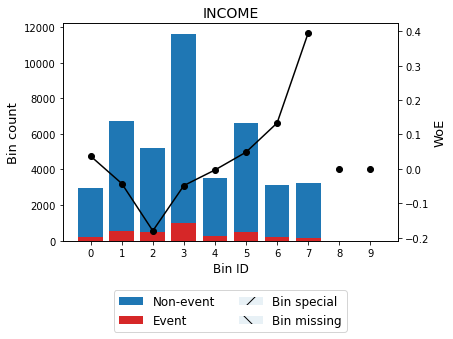

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 70168.50)",2958,0.068708,2727,231,0.078093,0.036825,9.174512e-05,1.146749e-05
1,"[70168.50, 111375.00)",6725,0.156206,6160,565,0.084015,-0.042709,2.900737e-04,3.625646e-05
2,"[111375.00, 123862.50)",5230,0.121481,4732,498,0.095220,-0.180212,4.255211e-03,5.311828e-04
3,"[123862.50, 177599.25)",11627,0.270069,10645,982,0.084459,-0.048461,6.472616e-04,8.089978e-05
4,"[177599.25, 180045.00)",3542,0.082273,3255,287,0.081028,-0.00325,8.699653e-07,1.087456e-07
5,"[180045.00, 247050.00)",6601,0.153326,6091,510,0.077261,0.048442,3.525693e-04,4.406685e-05
6,"[247050.00, 294084.00)",3150,0.073167,2925,225,0.071429,0.133234,1.228397e-03,1.534361e-04
7,"[294084.00, inf)",3219,0.074770,3039,180,0.055918,0.394612,9.880675e-03,1.227133e-03
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00


['(-inf, 70168.50)',
 '[70168.50, 111375.00)',
 '[111375.00, 123862.50)',
 '[123862.50, 177599.25)',
 '[177599.25, 180045.00)',
 '[180045.00, 247050.00)',
 '[247050.00, 294084.00)',
 '[294084.00, inf)',
 'Special',
 'Missing',
 '']

==
APPROVED_CREDIT


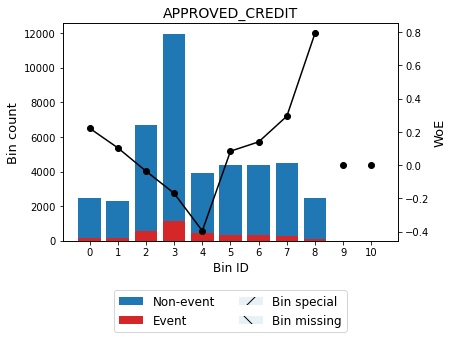

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 148252.50)",2478,0.057558,2315,163,0.065779,0.2217,0.002579,0.000322
1,"[148252.50, 184290.75)",2275,0.052843,2108,167,0.073407,0.103786,0.000545,0.000068
2,"[184290.75, 282314.25)",6693,0.155463,6134,559,0.083520,-0.036262,0.000208,0.000026
3,"[282314.25, 544770.00)",11969,0.278013,10840,1129,0.094327,-0.169804,0.008608,0.001075
4,"[544770.00, 668394.00)",3897,0.090518,3447,450,0.115473,-0.395703,0.016731,0.002078
5,"[668394.00, 792947.25)",4372,0.101552,4045,327,0.074794,0.083562,0.000685,0.000086
6,"[792947.25, 1002791.25)",4393,0.102039,4081,312,0.071022,0.139379,0.001870,0.000234
7,"[1002791.25, 1322255.25)",4490,0.104292,4214,276,0.061470,0.294052,0.007977,0.000994
8,"[1322255.25, inf)",2485,0.057721,2390,95,0.038229,0.793457,0.026246,0.003197
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, 148252.50)',
 '[148252.50, 184290.75)',
 '[184290.75, 282314.25)',
 '[282314.25, 544770.00)',
 '[544770.00, 668394.00)',
 '[668394.00, 792947.25)',
 '[792947.25, 1002791.25)',
 '[1002791.25, 1322255.25)',
 '[1322255.25, inf)',
 'Special',
 'Missing',
 '']

==
INCOME_TYPE


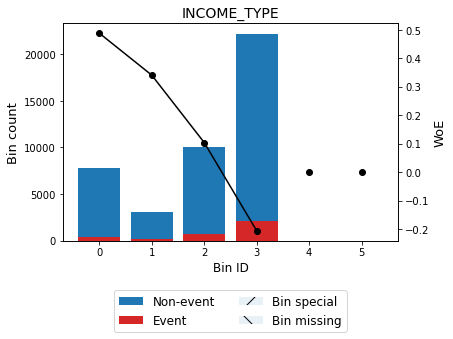

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Student, Pensioner]",7795,0.181060,7396,399,0.051187,0.488018,0.035220,0.004359
1,[State servant],3042,0.070659,2863,179,0.058843,0.340525,0.007110,0.000884
2,[Commercial associate],10011,0.232533,9276,735,0.073419,0.1036,0.002390,0.000299
3,"[Working, Unemployed]",22204,0.515748,20039,2165,0.097505,-0.206455,0.023973,0.002991
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.068692,0.008534


[array(['Student', 'Pensioner'], dtype=object),
 array(['State servant'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working', 'Unemployed'], dtype=object),
 'Special',
 'Missing',
 '']

==
EDUCATION


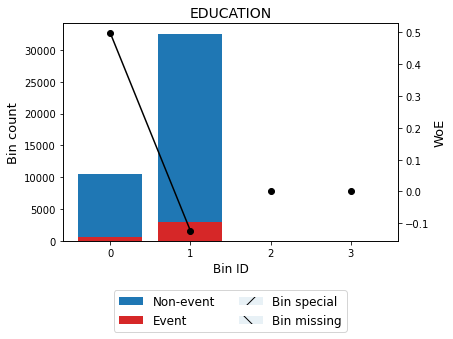

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Academic degree, Higher education]",10485,0.243543,9953,532,0.050739,0.497271,0.049002,0.006063
1,"[Incomplete higher, Secondary / secondary spec...",32567,0.756457,29621,2946,0.090460,-0.12368,0.012188,0.001522
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.061190,0.007585


[array(['Academic degree', 'Higher education'], dtype=object),
 array(['Incomplete higher', 'Secondary / secondary special',
        'Lower secondary'], dtype=object),
 'Special',
 'Missing',
 '']

==
FAMILY_STATUS


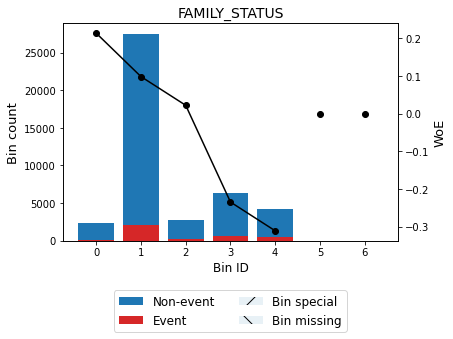

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Widow],2294,0.053284,2142,152,0.066260,0.2139,0.002230,0.000278
1,[Married],27520,0.639227,25490,2030,0.073765,0.098536,0.005956,0.000744
2,[Separated],2767,0.064271,2548,219,0.079147,0.022277,0.000032,0.000004
3,[Single / not married],6279,0.145847,5651,628,0.100016,-0.234667,0.008863,0.001105
4,[Civil marriage],4192,0.097371,3743,449,0.107109,-0.311095,0.010737,0.001337
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.027817,0.003468


[array(['Widow'], dtype=object),
 array(['Married'], dtype=object),
 array(['Separated'], dtype=object),
 array(['Single / not married'], dtype=object),
 array(['Civil marriage'], dtype=object),
 'Special',
 'Missing',
 '']

==
HOUSING_TYPE


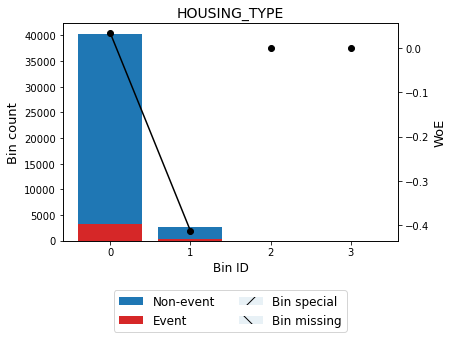

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Office apartment, Co-op apartment, House / ap...",40347,0.937169,37186,3161,0.078345,0.033329,0.001027,0.000128
1,"[With parents, Rented apartment]",2705,0.062831,2388,317,0.117190,-0.412405,0.012703,0.001577
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.013729,0.001705


[array(['Office apartment', 'Co-op apartment', 'House / apartment',
        'Municipal apartment'], dtype=object),
 array(['With parents', 'Rented apartment'], dtype=object),
 'Special',
 'Missing',
 '']

==
DAYS_REGISTRATION


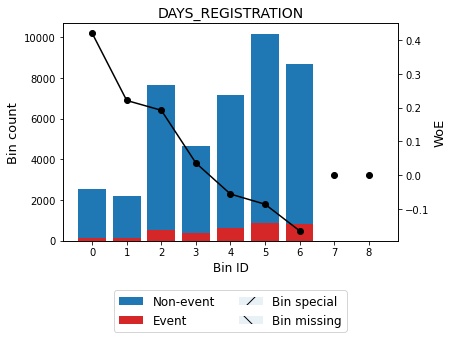

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -11003.50)",2548,0.059184,2409,139,0.054553,0.420778,0.008798,0.001092
1,"[-11003.50, -9728.50)",2173,0.050474,2030,143,0.065808,0.221232,0.002252,0.000281
2,"[-9728.50, -6942.50)",7661,0.177948,7143,518,0.067615,0.192198,0.006066,0.000757
3,"[-6942.50, -5507.50)",4644,0.107870,4281,363,0.078165,0.035824,0.000136,0.000017
4,"[-5507.50, -3954.50)",7160,0.166311,6551,609,0.085056,-0.05616,0.000537,0.000067
5,"[-3954.50, -1491.50)",10168,0.236180,9279,889,0.087431,-0.086303,0.001824,0.000228
6,"[-1491.50, inf)",8698,0.202035,7881,817,0.093930,-0.165144,0.005905,0.000737
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.025519,0.003179


['(-inf, -11003.50)',
 '[-11003.50, -9728.50)',
 '[-9728.50, -6942.50)',
 '[-6942.50, -5507.50)',
 '[-5507.50, -3954.50)',
 '[-3954.50, -1491.50)',
 '[-1491.50, inf)',
 'Special',
 'Missing',
 '']

==
DAYS_ID_CHANGE


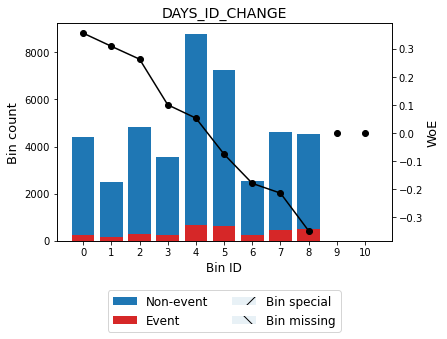

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -4717.50)",4393,0.102039,4138,255,0.058047,0.354989,0.011092,0.001379
1,"[-4717.50, -4537.50)",2506,0.058209,2354,152,0.060654,0.308276,0.004865,0.000606
2,"[-4537.50, -4243.50)",4833,0.112260,4527,306,0.063315,0.262515,0.006933,0.000864
3,"[-4243.50, -4033.50)",3571,0.082946,3308,263,0.073649,0.10023,0.000799,0.000100
4,"[-4033.50, -2884.50)",8798,0.204358,8121,677,0.076949,0.052822,0.000558,0.000070
5,"[-2884.50, -1860.50)",7266,0.168773,6637,629,0.086568,-0.075431,0.000991,0.000124
6,"[-1860.50, -1468.50)",2544,0.059091,2302,242,0.095126,-0.179119,0.002044,0.000255
7,"[-1468.50, -769.50)",4605,0.106964,4153,452,0.098154,-0.213811,0.005349,0.000667
8,"[-769.50, inf)",4536,0.105361,4034,502,0.110670,-0.347801,0.014747,0.001834
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, -4717.50)',
 '[-4717.50, -4537.50)',
 '[-4537.50, -4243.50)',
 '[-4243.50, -4033.50)',
 '[-4033.50, -2884.50)',
 '[-2884.50, -1860.50)',
 '[-1860.50, -1468.50)',
 '[-1468.50, -769.50)',
 '[-769.50, inf)',
 'Special',
 'Missing',
 '']

==
ORGANIZATION_TYPE


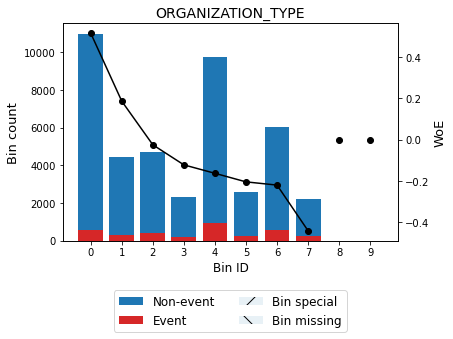

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Industry: type 8, Industry: type 6, Trade: ty...",10988,0.255226,10441,547,0.049782,0.517332,0.055127,0.006815
1,"[Emergency, Industry: type 11, Hotel, Transpor...",4458,0.103549,4155,303,0.067968,0.18662,0.003336,0.000416
2,"[Realtor, Industry: type 7, Kindergarten, Trad...",4692,0.108984,4304,388,0.082694,-0.02542,0.000071,0.000009
3,"[Housing, Trade: type 7, Business Entity Type 1]",2323,0.053958,2113,210,0.090400,-0.122958,0.000859,0.000107
4,"[Business Entity Type 3, Services]",9773,0.227005,8856,917,0.093830,-0.163972,0.006538,0.000816
5,"[Transport: type 4, Security, Business Entity ...",2607,0.060555,2353,254,0.097430,-0.205603,0.002790,0.000348
6,"[Self-employed, Agriculture, Trade: type 4, Le...",6011,0.139622,5417,594,0.098819,-0.221297,0.007503,0.000936
7,"[Restaurant, Advertising, Mobile, Construction...",2200,0.051101,1935,265,0.120455,-0.443582,0.012109,0.001501
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


[array(['Industry: type 8', 'Industry: type 6', 'Trade: type 5',
        'Insurance', 'Industry: type 12', 'Trade: type 6', 'Bank',
        'Transport: type 1', 'Police', 'Military', 'Telecom', 'University',
        'NA1', 'School', 'Security Ministries'], dtype=object),
 array(['Emergency', 'Industry: type 11', 'Hotel', 'Transport: type 2',
        'Government', 'Medicine', 'Industry: type 9', 'Industry: type 13',
        'Electricity'], dtype=object),
 array(['Realtor', 'Industry: type 7', 'Kindergarten', 'Trade: type 2',
        'Industry: type 5', 'Other', 'Culture', 'Postal', 'Trade: type 3'],
       dtype=object),
 array(['Housing', 'Trade: type 7', 'Business Entity Type 1'], dtype=object),
 array(['Business Entity Type 3', 'Services'], dtype=object),
 array(['Transport: type 4', 'Security', 'Business Entity Type 2'],
       dtype=object),
 array(['Self-employed', 'Agriculture', 'Trade: type 4', 'Legal Services',
        'Transport: type 3'], dtype=object),
 array(['Restaurant', 

==
EXT_SCORE_1


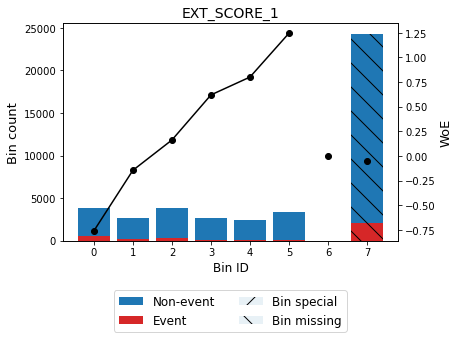

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.30)",3832,0.089009,3226,606,0.158142,-0.759597,0.070430,0.008598
1,"[0.30, 0.40)",2699,0.062692,2450,249,0.092256,-0.145325,0.001407,0.000176
2,"[0.40, 0.54)",3882,0.090170,3612,270,0.069552,0.16188,0.002208,0.000276
3,"[0.54, 0.64)",2612,0.060671,2494,118,0.045176,0.619244,0.018016,0.002217
4,"[0.64, 0.73)",2396,0.055654,2305,91,0.037980,0.800262,0.025673,0.003126
5,"[0.73, inf)",3324,0.077209,3242,82,0.024669,1.245512,0.072670,0.008539
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,24307,0.564596,22245,2062,0.084832,-0.053274,0.001639,0.000205
Totals,,43052,1.000000,39574,3478,0.080786,,0.192043,0.023136


['(-inf, 0.30)',
 '[0.30, 0.40)',
 '[0.40, 0.54)',
 '[0.54, 0.64)',
 '[0.64, 0.73)',
 '[0.73, inf)',
 'Special',
 'Missing',
 '']

==
EXT_SCORE_2


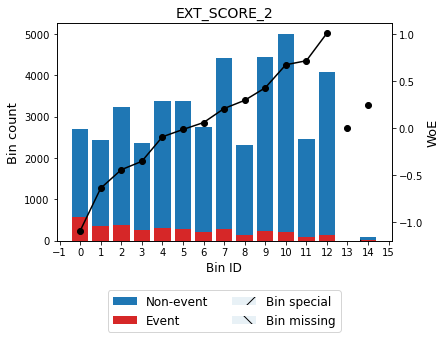

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.16)",2699,0.062692,2137,562,0.208225,-1.096059,0.117922,0.014044
1,"[0.16, 0.25)",2424,0.056304,2077,347,0.143152,-0.64236,0.030375,0.003733
2,"[0.25, 0.33)",3240,0.075258,2849,391,0.120679,-0.445699,0.018019,0.002234
3,"[0.33, 0.39)",2368,0.055003,2104,264,0.111486,-0.356068,0.008097,0.001007
4,"[0.39, 0.46)",3381,0.078533,3083,298,0.088140,-0.09515,0.000740,0.000092
5,"[0.46, 0.52)",3387,0.078672,3109,278,0.082079,-0.01728,0.000024,0.000003
6,"[0.52, 0.55)",2751,0.063899,2540,211,0.076699,0.056346,0.000198,0.000025
7,"[0.55, 0.60)",4404,0.102295,4110,294,0.066757,0.205884,0.003979,0.000496
8,"[0.60, 0.62)",2324,0.053981,2181,143,0.061532,0.292979,0.004101,0.000511
9,"[0.62, 0.66)",4441,0.103154,4200,241,0.054267,0.426328,0.015705,0.001948


['(-inf, 0.16)',
 '[0.16, 0.25)',
 '[0.25, 0.33)',
 '[0.33, 0.39)',
 '[0.39, 0.46)',
 '[0.46, 0.52)',
 '[0.52, 0.55)',
 '[0.55, 0.60)',
 '[0.60, 0.62)',
 '[0.62, 0.66)',
 '[0.66, 0.70)',
 '[0.70, 0.72)',
 '[0.72, inf)',
 'Special',
 'Missing',
 '']

==
EXT_SCORE_3


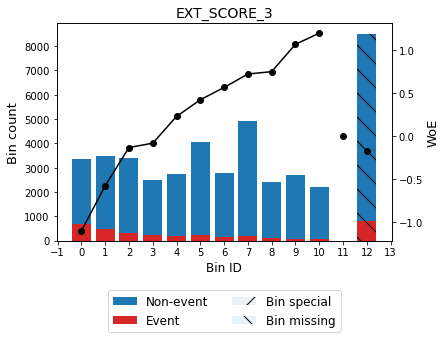

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.23)",3370,0.078277,2665,705,0.209199,-1.101953,0.149161,0.017756
1,"[0.23, 0.33)",3485,0.080949,3013,472,0.135438,-0.578002,0.034434,0.004245
2,"[0.33, 0.40)",3404,0.079067,3093,311,0.091363,-0.134611,0.001516,0.000189
3,"[0.40, 0.45)",2477,0.057535,2261,216,0.087202,-0.083431,0.000415,0.000052
4,"[0.45, 0.51)",2750,0.063876,2570,180,0.065455,0.226989,0.002993,0.000373
5,"[0.51, 0.57)",4051,0.094096,3830,221,0.054554,0.420742,0.013985,0.001735
6,"[0.57, 0.62)",2791,0.064829,2658,133,0.047653,0.563265,0.016292,0.002010
7,"[0.62, 0.69)",4923,0.114350,4721,202,0.041032,0.719793,0.044063,0.005392
8,"[0.69, 0.72)",2402,0.055793,2306,96,0.039967,0.747207,0.022916,0.002800
9,"[0.72, 0.77)",2685,0.062366,2606,79,0.029423,1.064409,0.045916,0.005483


['(-inf, 0.23)',
 '[0.23, 0.33)',
 '[0.33, 0.40)',
 '[0.40, 0.45)',
 '[0.45, 0.51)',
 '[0.51, 0.57)',
 '[0.57, 0.62)',
 '[0.62, 0.69)',
 '[0.69, 0.72)',
 '[0.72, 0.77)',
 '[0.77, inf)',
 'Special',
 'Missing',
 '']

==
terms_payment


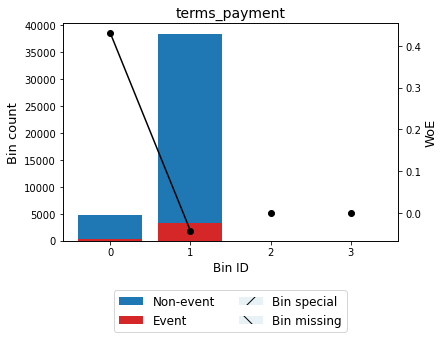

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10.84)",4679,0.108683,4426,253,0.054071,0.430147,0.016818,0.002086
1,"[10.84, inf)",38372,0.891294,35147,3225,0.084046,-0.043109,0.001687,0.000211
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,1,0.000023,1,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.018505,0.002297


['(-inf, 10.84)', '[10.84, inf)', 'Special', 'Missing', '']

==
credit_per_income


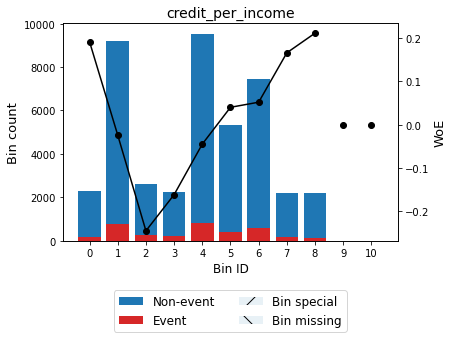

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.00)",2306,0.053563,2150,156,0.067650,0.191652,0.001816,0.000227
1,"[1.00, 2.11)",9201,0.213718,8441,760,0.082600,-0.024177,0.000126,0.000016
2,"[2.11, 2.40)",2604,0.060485,2341,263,0.100998,-0.245535,0.004042,0.000504
3,"[2.40, 2.64)",2253,0.052332,2042,211,0.093653,-0.161888,0.001468,0.000183
4,"[2.64, 3.89)",9539,0.221569,8736,803,0.084181,-0.044862,0.000454,0.000057
5,"[3.89, 4.98)",5318,0.123525,4904,414,0.077849,0.040226,0.000197,0.000025
6,"[4.98, 7.43)",7467,0.173441,6892,575,0.077005,0.052032,0.000459,0.000057
7,"[7.43, 9.16)",2180,0.050636,2029,151,0.069266,0.166304,0.001306,0.000163
8,"[9.16, inf)",2184,0.050729,2039,145,0.066392,0.211766,0.002082,0.000260
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, 1.00)',
 '[1.00, 2.11)',
 '[2.11, 2.40)',
 '[2.40, 2.64)',
 '[2.64, 3.89)',
 '[3.89, 4.98)',
 '[4.98, 7.43)',
 '[7.43, 9.16)',
 '[9.16, inf)',
 'Special',
 'Missing',
 '']

==
Approved


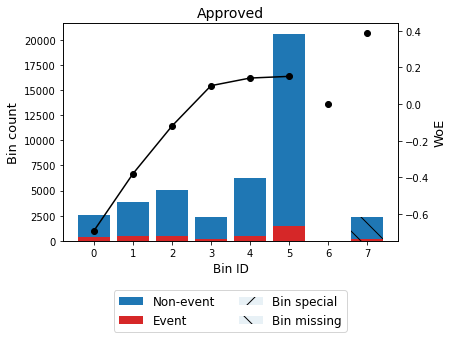

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.31)",2595,0.060276,2207,388,0.149518,-0.693331,0.038681,0.004740
1,"[0.31, 0.45)",3806,0.088405,3372,434,0.114030,-0.381498,0.015099,0.001876
2,"[0.45, 0.57)",5099,0.118438,4639,460,0.090214,-0.120687,0.001815,0.000227
3,"[0.57, 0.63)",2335,0.054237,2163,172,0.073662,0.100042,0.000521,0.000065
4,"[0.63, 0.77)",6251,0.145197,5808,443,0.070869,0.141707,0.002748,0.000343
5,"[0.77, inf)",20622,0.479002,19173,1449,0.070265,0.150914,0.010242,0.001279
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,2344,0.054446,2212,132,0.056314,0.387136,0.006946,0.000863
Totals,,43052,1.000000,39574,3478,0.080786,,0.076050,0.009393


['(-inf, 0.31)',
 '[0.31, 0.45)',
 '[0.45, 0.57)',
 '[0.57, 0.63)',
 '[0.63, 0.77)',
 '[0.77, inf)',
 'Special',
 'Missing',
 '']

==
Refused


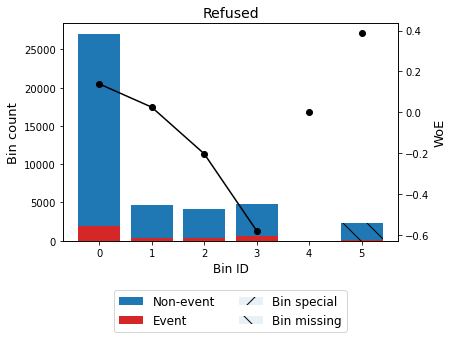

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.09)",27052,0.628356,25130,1922,0.071048,0.138981,0.011452,0.001430
1,"[0.09, 0.23)",4713,0.109472,4341,372,0.078931,0.025251,0.000069,0.000009
2,"[0.23, 0.35)",4178,0.097045,3772,406,0.097176,-0.202707,0.004342,0.000542
3,"[0.35, inf)",4765,0.110680,4119,646,0.135572,-0.579149,0.047291,0.005830
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,2344,0.054446,2212,132,0.056314,0.387136,0.006946,0.000863
Totals,,43052,1.000000,39574,3478,0.080786,,0.070099,0.008674


['(-inf, 0.09)',
 '[0.09, 0.23)',
 '[0.23, 0.35)',
 '[0.35, inf)',
 'Special',
 'Missing',
 '']

==
Unused offer


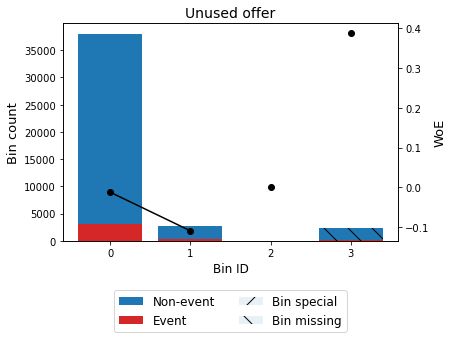

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.05)",38053,0.883885,34944,3109,0.081702,-0.012269,0.000134,0.000017
1,"[0.05, inf)",2655,0.061670,2418,237,0.089266,-0.109079,0.000768,0.000096
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,2344,0.054446,2212,132,0.056314,0.387136,0.006946,0.000863
Totals,,43052,1.000000,39574,3478,0.080786,,0.007848,0.000976


['(-inf, 0.05)', '[0.05, inf)', 'Special', 'Missing', '']

==
overdue_days


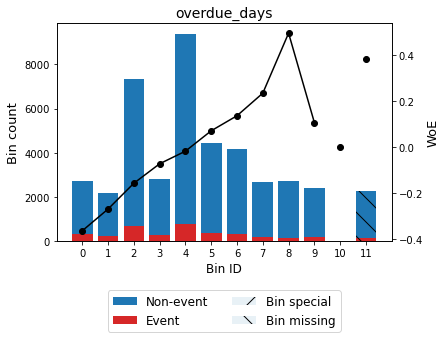

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 36.50)",2696,0.062622,2393,303,0.112389,-0.365145,0.009731,0.001210
1,"[36.50, 62.50)",2178,0.050590,1953,225,0.103306,-0.270693,0.004153,0.000518
2,"[62.50, 137.50)",7346,0.170631,6660,686,0.093384,-0.158718,0.004594,0.000574
3,"[137.50, 169.50)",2799,0.065014,2557,242,0.086459,-0.074063,0.000368,0.000046
4,"[169.50, 311.50)",9400,0.218341,8627,773,0.082234,-0.019342,0.000082,0.000010
5,"[311.50, 416.50)",4446,0.103270,4109,337,0.075798,0.069137,0.000480,0.000060
6,"[416.50, 568.50)",4149,0.096372,3853,296,0.071342,0.134533,0.001649,0.000206
7,"[568.50, 732.50)",2672,0.062064,2498,174,0.065120,0.232475,0.003044,0.000380
8,"[732.50, 1057.50)",2709,0.062924,2571,138,0.050941,0.493082,0.012470,0.001543
9,"[1057.50, inf)",2414,0.056072,2237,177,0.073322,0.105026,0.000592,0.000074


['(-inf, 36.50)',
 '[36.50, 62.50)',
 '[62.50, 137.50)',
 '[137.50, 169.50)',
 '[169.50, 311.50)',
 '[311.50, 416.50)',
 '[416.50, 568.50)',
 '[568.50, 732.50)',
 '[732.50, 1057.50)',
 '[1057.50, inf)',
 'Special',
 'Missing',
 '']

==
overdue_amt


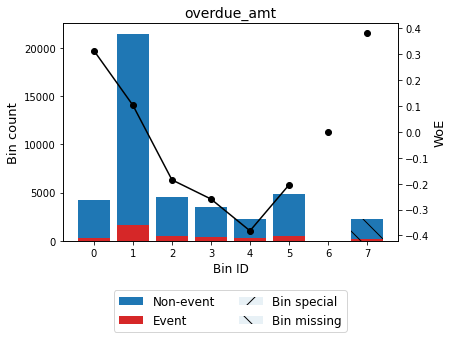

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -18764.75)",4240,0.098486,3984,256,0.060377,0.313149,0.008476,0.001055
1,"[-18764.75, 1936.53)",21490,0.499164,19910,1580,0.073523,0.102082,0.004984,0.000623
2,"[1936.53, 14434.22)",4588,0.106569,4149,439,0.095684,-0.185592,0.003968,0.000495
3,"[14434.22, 32268.13)",3471,0.080623,3116,355,0.102276,-0.259527,0.006055,0.000755
4,"[32268.13, 55427.29)",2226,0.051705,1972,254,0.114106,-0.382246,0.008868,0.001102
5,"[55427.29, inf)",4796,0.111400,4329,467,0.097373,-0.204952,0.005100,0.000636
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,2241,0.052053,2114,127,0.056671,0.380435,0.006431,0.000799
Totals,,43052,1.000000,39574,3478,0.080786,,0.043882,0.005465


['(-inf, -18764.75)',
 '[-18764.75, 1936.53)',
 '[1936.53, 14434.22)',
 '[14434.22, 32268.13)',
 '[32268.13, 55427.29)',
 '[55427.29, inf)',
 'Special',
 'Missing',
 '']

==
has_overdue_day


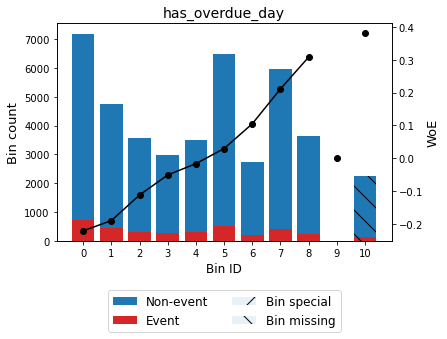

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.50)",7194,0.167100,6484,710,0.098693,-0.219887,0.008860,0.001105
1,"[8.50, 11.50)",4752,0.110378,4296,456,0.095960,-0.188768,0.004257,0.000531
2,"[11.50, 14.50)",3578,0.083109,3258,320,0.089435,-0.111167,0.001076,0.000134
3,"[14.50, 17.50)",2979,0.069195,2727,252,0.084592,-0.050187,0.000178,0.000022
4,"[17.50, 21.50)",3489,0.081042,3203,286,0.081972,-0.015864,0.000021,0.000003
5,"[21.50, 31.50)",6490,0.150748,5980,510,0.078582,0.03005,0.000134,0.000017
6,"[31.50, 37.50)",2728,0.063365,2528,200,0.073314,0.105151,0.000670,0.000084
7,"[37.50, 61.50)",5976,0.138809,5579,397,0.066432,0.211114,0.005664,0.000707
8,"[61.50, inf)",3625,0.084201,3405,220,0.060690,0.307658,0.007010,0.000873
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, 8.50)',
 '[8.50, 11.50)',
 '[11.50, 14.50)',
 '[14.50, 17.50)',
 '[17.50, 21.50)',
 '[21.50, 31.50)',
 '[31.50, 37.50)',
 '[37.50, 61.50)',
 '[61.50, inf)',
 'Special',
 'Missing',
 '']

==
has_overdue_amt


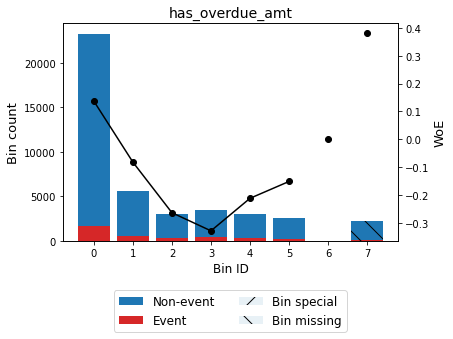

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",23261,0.540300,21605,1656,0.071192,0.136805,0.009549,0.001193
1,"[0.50, 2.50)",5583,0.129680,5097,486,0.087050,-0.081516,0.000892,0.000111
2,"[2.50, 4.50)",3023,0.070217,2713,310,0.102547,-0.262477,0.005401,0.000673
3,"[4.50, 9.50)",3405,0.079090,3035,370,0.108664,-0.327251,0.009716,0.001209
4,"[9.50, 16.50)",2993,0.069521,2700,293,0.097895,-0.21088,0.003378,0.000421
5,"[16.50, inf)",2546,0.059138,2310,236,0.092694,-0.150544,0.001428,0.000178
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,2241,0.052053,2114,127,0.056671,0.380435,0.006431,0.000799
Totals,,43052,1.000000,39574,3478,0.080786,,0.036795,0.004585


['(-inf, 0.50)',
 '[0.50, 2.50)',
 '[2.50, 4.50)',
 '[4.50, 9.50)',
 '[9.50, 16.50)',
 '[16.50, inf)',
 'Special',
 'Missing',
 '']

==
insure_rate


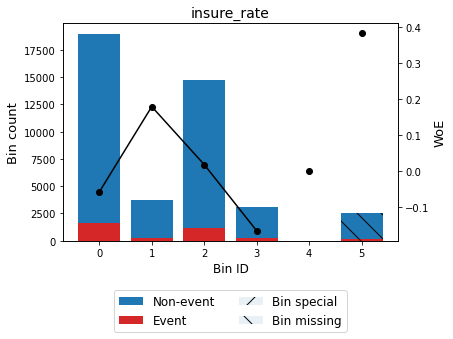

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.03)",18988,0.441048,17369,1619,0.085264,-0.058837,0.001565,0.000196
1,"[0.03, 0.29)",3711,0.086198,3457,254,0.068445,0.179107,0.002566,0.000320
2,"[0.29, 0.90)",14768,0.343027,13594,1174,0.079496,0.017497,0.000104,0.000013
3,"[0.90, inf)",3071,0.071332,2782,289,0.094106,-0.167216,0.002140,0.000267
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,2514,0.058394,2372,142,0.056484,0.383947,0.007337,0.000912
Totals,,43052,1.000000,39574,3478,0.080786,,0.013712,0.001708


['(-inf, 0.03)',
 '[0.03, 0.29)',
 '[0.29, 0.90)',
 '[0.90, inf)',
 'Special',
 'Missing',
 '']

==
year_age


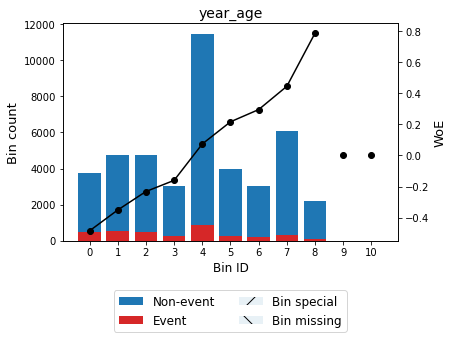

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 27.77)",3772,0.087615,3301,471,0.124867,-0.484592,0.025203,0.003120
1,"[27.77, 31.98)",4732,0.109914,4207,525,0.110947,-0.350608,0.015652,0.001947
2,"[31.98, 36.33)",4752,0.110378,4278,474,0.099747,-0.231681,0.006530,0.000814
3,"[36.33, 38.77)",3059,0.071054,2773,286,0.093495,-0.160022,0.001946,0.000243
4,"[38.77, 49.24)",11477,0.266585,10611,866,0.075455,0.074047,0.001417,0.000177
5,"[49.24, 53.43)",3964,0.092075,3702,262,0.066095,0.216569,0.003945,0.000492
6,"[53.43, 56.51)",3029,0.070357,2843,186,0.061406,0.295154,0.005419,0.000675
7,"[56.51, 63.51)",6058,0.140714,5735,323,0.053318,0.444976,0.023161,0.002871
8,"[63.51, inf)",2209,0.051310,2124,85,0.038479,0.78669,0.022997,0.002803
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, 27.77)',
 '[27.77, 31.98)',
 '[31.98, 36.33)',
 '[36.33, 38.77)',
 '[38.77, 49.24)',
 '[49.24, 53.43)',
 '[53.43, 56.51)',
 '[56.51, 63.51)',
 '[63.51, inf)',
 'Special',
 'Missing',
 '']

==
year_work


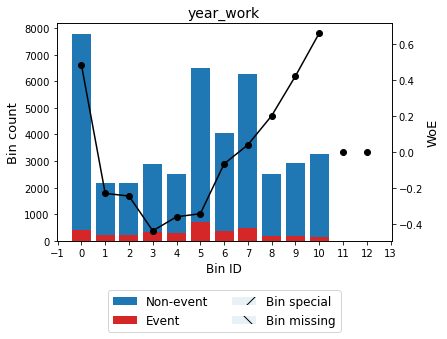

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.02)",7797,0.181107,7397,400,0.051302,0.48565,0.034922,0.004323
1,"[0.02, 0.62)",2173,0.050474,1957,216,0.099402,-0.227825,0.002883,0.000360
2,"[0.62, 1.06)",2174,0.050497,1955,219,0.100736,-0.242641,0.003292,0.000410
3,"[1.06, 1.72)",2884,0.066989,2539,345,0.119626,-0.435734,0.015267,0.001893
4,"[1.72, 2.30)",2499,0.058046,2220,279,0.111645,-0.357664,0.008627,0.001073
5,"[2.30, 4.05)",6501,0.151003,5786,715,0.109983,-0.340801,0.020234,0.002517
6,"[4.05, 5.49)",4062,0.094351,3714,348,0.085672,-0.064053,0.000398,0.000050
7,"[5.49, 8.80)",6277,0.145800,5789,488,0.077744,0.041685,0.000249,0.000031
8,"[8.80, 10.89)",2495,0.057953,2328,167,0.066934,0.203056,0.002195,0.000274
9,"[10.89, 14.90)",2940,0.068290,2780,160,0.054422,0.423317,0.010263,0.001273


['(-inf, 0.02)',
 '[0.02, 0.62)',
 '[0.62, 1.06)',
 '[1.06, 1.72)',
 '[1.72, 2.30)',
 '[2.30, 4.05)',
 '[4.05, 5.49)',
 '[5.49, 8.80)',
 '[8.80, 10.89)',
 '[10.89, 14.90)',
 '[14.90, inf)',
 'Special',
 'Missing',
 '']

==


BinningProcess(binning_fit_params={'APPROVED_CREDIT': {'dtype': 'numerical',
                                                       'solver': 'cp'},
                                   'Approved': {'dtype': 'numerical',
                                                'solver': 'cp'},
                                   'CONTRACT_TYPE': {'dtype': 'categorical',
                                                     'solver': 'cp'},
                                   'DAYS_ID_CHANGE': {'dtype': 'numerical',
                                                      'solver': 'cp'},
                                   'DAYS_REGISTRATION': {'dtype': 'numerical',
                                                         'solver': 'cp'},
                                   'EDUCATION': {'dtype': 'categorical',
                                                 'solver': 'cp'},
                                   '...
       'APPROVED_CREDIT', 'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS',
       'HOUSING_TYP

In [34]:
create_binning(train,bfp)

## monotonic binning and override the binning

From automatical optimal binning we wish to adjust these:
- num_children: should be ascending
- income: should be descending
- approve_credit: auto
- annuity: should be ascending
- price: should beascending
- days_work: auto

In [35]:
train.columns.values

array(['TARGET', 'CONTRACT_TYPE', 'GENDER', 'NUM_CHILDREN', 'INCOME',
       'APPROVED_CREDIT', 'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS',
       'HOUSING_TYPE', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE',
       'ORGANIZATION_TYPE', 'EXT_SCORE_1', 'EXT_SCORE_2', 'EXT_SCORE_3',
       'terms_payment', 'credit_per_income', 'Approved', 'Refused',
       'Unused offer', 'overdue_days', 'overdue_amt', 'has_overdue_day',
       'has_overdue_amt', 'insure_rate', 'year_age', 'year_work'],
      dtype=object)

In [36]:
user_split_income_type=[['Student', 'Pensioner'],
 ['State servant'],
 ['Commercial associate'],
 ['Working'], ['Unemployed']]
user_split_income_fixed=[False,False,False,True,True]
user_split_income_type

[['Student', 'Pensioner'],
 ['State servant'],
 ['Commercial associate'],
 ['Working'],
 ['Unemployed']]

d:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


CONTRACT_TYPE


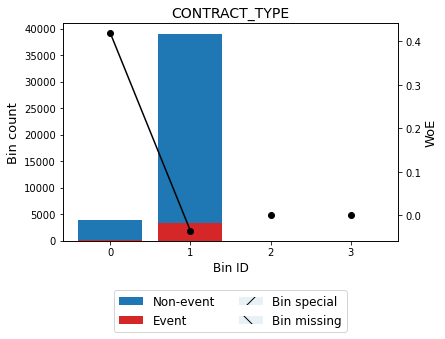

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Revolving loans],3988,0.092632,3770,218,0.054664,0.41862,0.013641,0.001693
1,[Cash loans],39064,0.907368,35804,3260,0.083453,-0.035382,0.001153,0.000144
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.014794,0.001837


[array(['Revolving loans'], dtype=object),
 array(['Cash loans'], dtype=object),
 'Special',
 'Missing',
 '']

==
GENDER


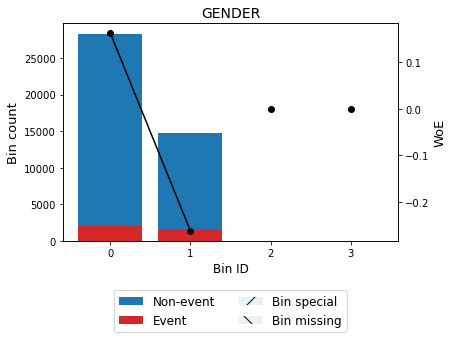

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[F],28336,0.658181,26366,1970,0.069523,0.162327,0.016205,0.002023
1,[M],14716,0.341819,13208,1508,0.102473,-0.261676,0.026123,0.003256
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.042327,0.005279


[array(['F'], dtype=object),
 array(['M'], dtype=object),
 'Special',
 'Missing',
 '']

==
NUM_CHILDREN


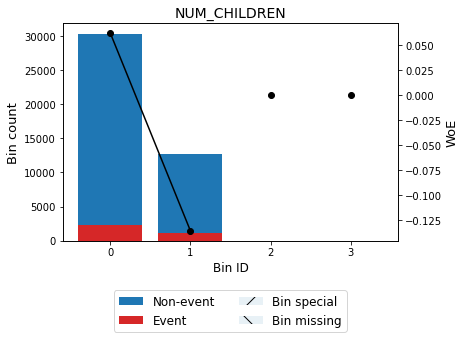

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",30313,0.704102,28000,2313,0.076304,0.061944,0.002632,0.000329
1,"[0.50, inf)",12739,0.295898,11574,1165,0.091451,-0.135675,0.005766,0.000720
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.008398,0.001049


['(-inf, 0.50)', '[0.50, inf)', 'Special', 'Missing', '']

==
INCOME


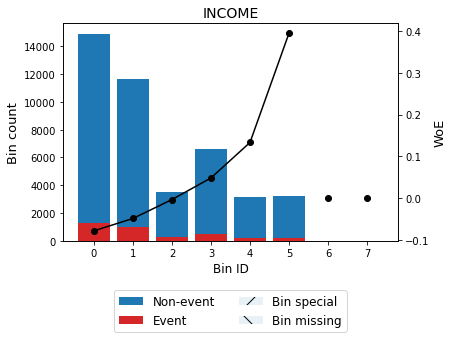

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 123862.50)",14913,0.346395,13619,1294,0.086770,-0.077987,2.176843e-03,2.720365e-04
1,"[123862.50, 177599.25)",11627,0.270069,10645,982,0.084459,-0.048461,6.472616e-04,8.089978e-05
2,"[177599.25, 180045.00)",3542,0.082273,3255,287,0.081028,-0.00325,8.699653e-07,1.087456e-07
3,"[180045.00, 247050.00)",6601,0.153326,6091,510,0.077261,0.048442,3.525693e-04,4.406685e-05
4,"[247050.00, 294084.00)",3150,0.073167,2925,225,0.071429,0.133234,1.228397e-03,1.534361e-04
5,"[294084.00, inf)",3219,0.074770,3039,180,0.055918,0.394612,9.880675e-03,1.227133e-03
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
Totals,,43052,1.000000,39574,3478,0.080786,,1.428662e-02,1.777681e-03


['(-inf, 123862.50)',
 '[123862.50, 177599.25)',
 '[177599.25, 180045.00)',
 '[180045.00, 247050.00)',
 '[247050.00, 294084.00)',
 '[294084.00, inf)',
 'Special',
 'Missing',
 '']

==
APPROVED_CREDIT


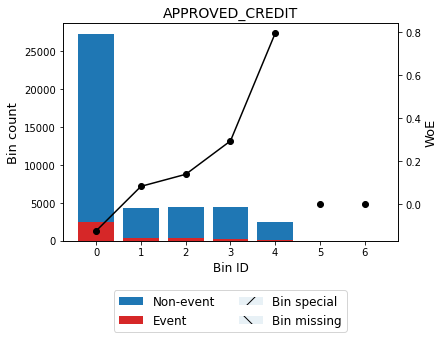

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 668394.00)",27312,0.634396,24844,2468,0.090363,-0.122507,0.010023,0.001252
1,"[668394.00, 792947.25)",4372,0.101552,4045,327,0.074794,0.083562,0.000685,0.000086
2,"[792947.25, 1002791.25)",4393,0.102039,4081,312,0.071022,0.139379,0.001870,0.000234
3,"[1002791.25, 1322255.25)",4490,0.104292,4214,276,0.061470,0.294052,0.007977,0.000994
4,"[1322255.25, inf)",2485,0.057721,2390,95,0.038229,0.793457,0.026246,0.003197
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.046801,0.005762


['(-inf, 668394.00)',
 '[668394.00, 792947.25)',
 '[792947.25, 1002791.25)',
 '[1002791.25, 1322255.25)',
 '[1322255.25, inf)',
 'Special',
 'Missing',
 '']

==
INCOME_TYPE


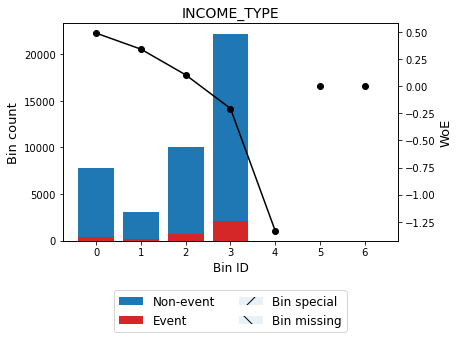

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Student, Pensioner]",7795,0.181060,7396,399,0.051187,0.488018,0.035220,0.004359
1,[State servant],3042,0.070659,2863,179,0.058843,0.340525,0.007110,0.000884
2,[Commercial associate],10011,0.232533,9276,735,0.073419,0.1036,0.002390,0.000299
3,[Working],22200,0.515655,20036,2164,0.097477,-0.206143,0.023893,0.002981
4,[Unemployed],4,0.000093,3,1,0.250000,-1.333103,0.000282,0.000033
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.068895,0.008557


[['Student', 'Pensioner'],
 ['State servant'],
 ['Commercial associate'],
 ['Working'],
 ['Unemployed'],
 'Special',
 'Missing',
 '']

==
EDUCATION


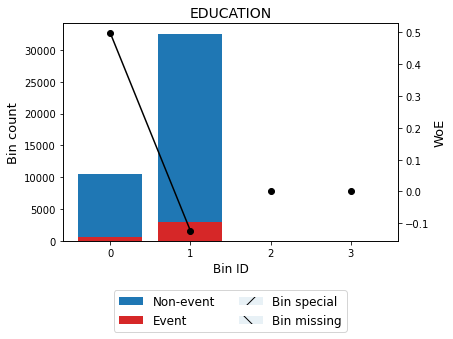

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Academic degree, Higher education]",10485,0.243543,9953,532,0.050739,0.497271,0.049002,0.006063
1,"[Incomplete higher, Secondary / secondary spec...",32567,0.756457,29621,2946,0.090460,-0.12368,0.012188,0.001522
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.061190,0.007585


[array(['Academic degree', 'Higher education'], dtype=object),
 array(['Incomplete higher', 'Secondary / secondary special',
        'Lower secondary'], dtype=object),
 'Special',
 'Missing',
 '']

==
FAMILY_STATUS


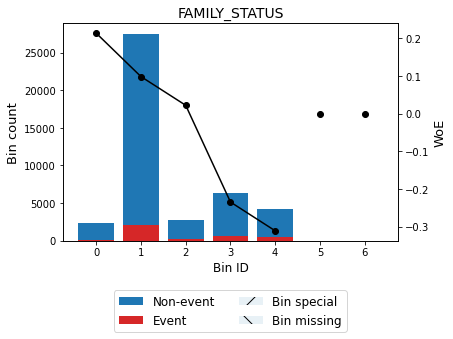

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Widow],2294,0.053284,2142,152,0.066260,0.2139,0.002230,0.000278
1,[Married],27520,0.639227,25490,2030,0.073765,0.098536,0.005956,0.000744
2,[Separated],2767,0.064271,2548,219,0.079147,0.022277,0.000032,0.000004
3,[Single / not married],6279,0.145847,5651,628,0.100016,-0.234667,0.008863,0.001105
4,[Civil marriage],4192,0.097371,3743,449,0.107109,-0.311095,0.010737,0.001337
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.027817,0.003468


[array(['Widow'], dtype=object),
 array(['Married'], dtype=object),
 array(['Separated'], dtype=object),
 array(['Single / not married'], dtype=object),
 array(['Civil marriage'], dtype=object),
 'Special',
 'Missing',
 '']

==
HOUSING_TYPE


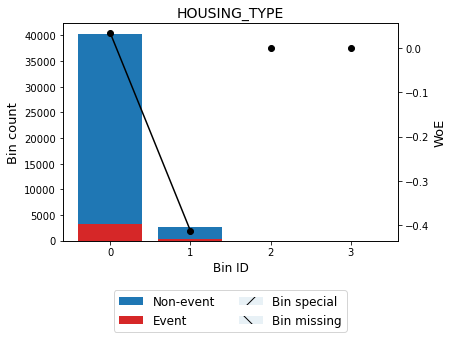

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Office apartment, Co-op apartment, House / ap...",40347,0.937169,37186,3161,0.078345,0.033329,0.001027,0.000128
1,"[With parents, Rented apartment]",2705,0.062831,2388,317,0.117190,-0.412405,0.012703,0.001577
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.013729,0.001705


[array(['Office apartment', 'Co-op apartment', 'House / apartment',
        'Municipal apartment'], dtype=object),
 array(['With parents', 'Rented apartment'], dtype=object),
 'Special',
 'Missing',
 '']

==
DAYS_REGISTRATION


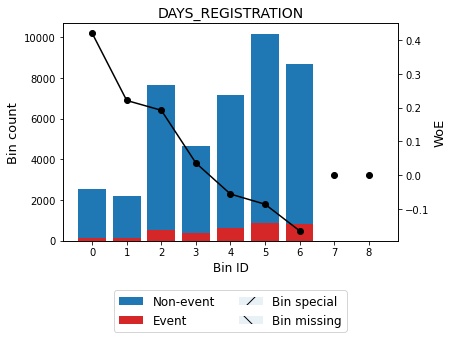

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -11003.50)",2548,0.059184,2409,139,0.054553,0.420778,0.008798,0.001092
1,"[-11003.50, -9728.50)",2173,0.050474,2030,143,0.065808,0.221232,0.002252,0.000281
2,"[-9728.50, -6942.50)",7661,0.177948,7143,518,0.067615,0.192198,0.006066,0.000757
3,"[-6942.50, -5507.50)",4644,0.107870,4281,363,0.078165,0.035824,0.000136,0.000017
4,"[-5507.50, -3954.50)",7160,0.166311,6551,609,0.085056,-0.05616,0.000537,0.000067
5,"[-3954.50, -1491.50)",10168,0.236180,9279,889,0.087431,-0.086303,0.001824,0.000228
6,"[-1491.50, inf)",8698,0.202035,7881,817,0.093930,-0.165144,0.005905,0.000737
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.025519,0.003179


['(-inf, -11003.50)',
 '[-11003.50, -9728.50)',
 '[-9728.50, -6942.50)',
 '[-6942.50, -5507.50)',
 '[-5507.50, -3954.50)',
 '[-3954.50, -1491.50)',
 '[-1491.50, inf)',
 'Special',
 'Missing',
 '']

==
DAYS_ID_CHANGE


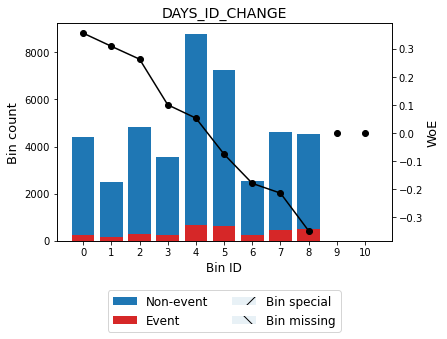

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -4717.50)",4393,0.102039,4138,255,0.058047,0.354989,0.011092,0.001379
1,"[-4717.50, -4537.50)",2506,0.058209,2354,152,0.060654,0.308276,0.004865,0.000606
2,"[-4537.50, -4243.50)",4833,0.112260,4527,306,0.063315,0.262515,0.006933,0.000864
3,"[-4243.50, -4033.50)",3571,0.082946,3308,263,0.073649,0.10023,0.000799,0.000100
4,"[-4033.50, -2884.50)",8798,0.204358,8121,677,0.076949,0.052822,0.000558,0.000070
5,"[-2884.50, -1860.50)",7266,0.168773,6637,629,0.086568,-0.075431,0.000991,0.000124
6,"[-1860.50, -1468.50)",2544,0.059091,2302,242,0.095126,-0.179119,0.002044,0.000255
7,"[-1468.50, -769.50)",4605,0.106964,4153,452,0.098154,-0.213811,0.005349,0.000667
8,"[-769.50, inf)",4536,0.105361,4034,502,0.110670,-0.347801,0.014747,0.001834
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, -4717.50)',
 '[-4717.50, -4537.50)',
 '[-4537.50, -4243.50)',
 '[-4243.50, -4033.50)',
 '[-4033.50, -2884.50)',
 '[-2884.50, -1860.50)',
 '[-1860.50, -1468.50)',
 '[-1468.50, -769.50)',
 '[-769.50, inf)',
 'Special',
 'Missing',
 '']

==
ORGANIZATION_TYPE


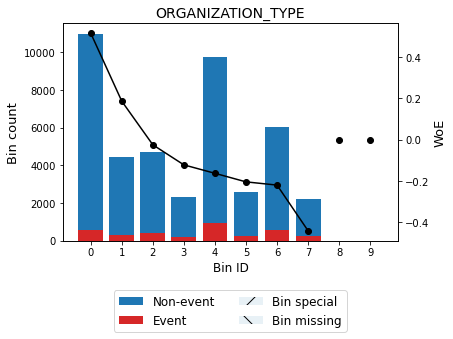

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Industry: type 8, Industry: type 6, Trade: ty...",10988,0.255226,10441,547,0.049782,0.517332,0.055127,0.006815
1,"[Emergency, Industry: type 11, Hotel, Transpor...",4458,0.103549,4155,303,0.067968,0.18662,0.003336,0.000416
2,"[Realtor, Industry: type 7, Kindergarten, Trad...",4692,0.108984,4304,388,0.082694,-0.02542,0.000071,0.000009
3,"[Housing, Trade: type 7, Business Entity Type 1]",2323,0.053958,2113,210,0.090400,-0.122958,0.000859,0.000107
4,"[Business Entity Type 3, Services]",9773,0.227005,8856,917,0.093830,-0.163972,0.006538,0.000816
5,"[Transport: type 4, Security, Business Entity ...",2607,0.060555,2353,254,0.097430,-0.205603,0.002790,0.000348
6,"[Self-employed, Agriculture, Trade: type 4, Le...",6011,0.139622,5417,594,0.098819,-0.221297,0.007503,0.000936
7,"[Restaurant, Advertising, Mobile, Construction...",2200,0.051101,1935,265,0.120455,-0.443582,0.012109,0.001501
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


[array(['Industry: type 8', 'Industry: type 6', 'Trade: type 5',
        'Insurance', 'Industry: type 12', 'Trade: type 6', 'Bank',
        'Transport: type 1', 'Police', 'Military', 'Telecom', 'University',
        'NA1', 'School', 'Security Ministries'], dtype=object),
 array(['Emergency', 'Industry: type 11', 'Hotel', 'Transport: type 2',
        'Government', 'Medicine', 'Industry: type 9', 'Industry: type 13',
        'Electricity'], dtype=object),
 array(['Realtor', 'Industry: type 7', 'Kindergarten', 'Trade: type 2',
        'Industry: type 5', 'Other', 'Culture', 'Postal', 'Trade: type 3'],
       dtype=object),
 array(['Housing', 'Trade: type 7', 'Business Entity Type 1'], dtype=object),
 array(['Business Entity Type 3', 'Services'], dtype=object),
 array(['Transport: type 4', 'Security', 'Business Entity Type 2'],
       dtype=object),
 array(['Self-employed', 'Agriculture', 'Trade: type 4', 'Legal Services',
        'Transport: type 3'], dtype=object),
 array(['Restaurant', 

==
EXT_SCORE_1


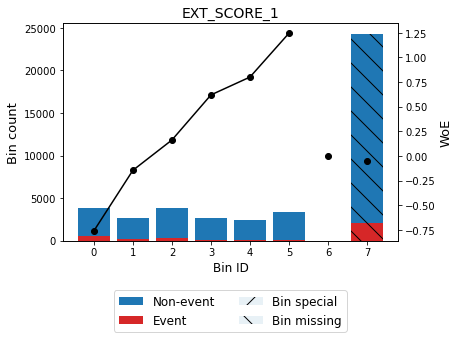

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.30)",3832,0.089009,3226,606,0.158142,-0.759597,0.070430,0.008598
1,"[0.30, 0.40)",2699,0.062692,2450,249,0.092256,-0.145325,0.001407,0.000176
2,"[0.40, 0.54)",3882,0.090170,3612,270,0.069552,0.16188,0.002208,0.000276
3,"[0.54, 0.64)",2612,0.060671,2494,118,0.045176,0.619244,0.018016,0.002217
4,"[0.64, 0.73)",2396,0.055654,2305,91,0.037980,0.800262,0.025673,0.003126
5,"[0.73, inf)",3324,0.077209,3242,82,0.024669,1.245512,0.072670,0.008539
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,24307,0.564596,22245,2062,0.084832,-0.053274,0.001639,0.000205
Totals,,43052,1.000000,39574,3478,0.080786,,0.192043,0.023136


['(-inf, 0.30)',
 '[0.30, 0.40)',
 '[0.40, 0.54)',
 '[0.54, 0.64)',
 '[0.64, 0.73)',
 '[0.73, inf)',
 'Special',
 'Missing',
 '']

==
EXT_SCORE_2


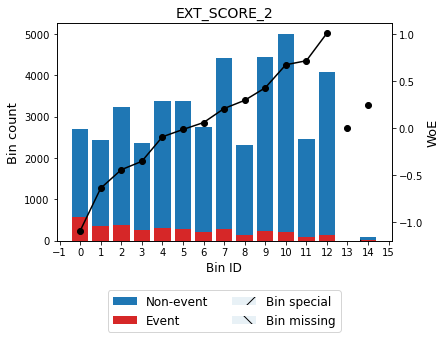

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.16)",2699,0.062692,2137,562,0.208225,-1.096059,0.117922,0.014044
1,"[0.16, 0.25)",2424,0.056304,2077,347,0.143152,-0.64236,0.030375,0.003733
2,"[0.25, 0.33)",3240,0.075258,2849,391,0.120679,-0.445699,0.018019,0.002234
3,"[0.33, 0.39)",2368,0.055003,2104,264,0.111486,-0.356068,0.008097,0.001007
4,"[0.39, 0.46)",3381,0.078533,3083,298,0.088140,-0.09515,0.000740,0.000092
5,"[0.46, 0.52)",3387,0.078672,3109,278,0.082079,-0.01728,0.000024,0.000003
6,"[0.52, 0.55)",2751,0.063899,2540,211,0.076699,0.056346,0.000198,0.000025
7,"[0.55, 0.60)",4404,0.102295,4110,294,0.066757,0.205884,0.003979,0.000496
8,"[0.60, 0.62)",2324,0.053981,2181,143,0.061532,0.292979,0.004101,0.000511
9,"[0.62, 0.66)",4441,0.103154,4200,241,0.054267,0.426328,0.015705,0.001948


['(-inf, 0.16)',
 '[0.16, 0.25)',
 '[0.25, 0.33)',
 '[0.33, 0.39)',
 '[0.39, 0.46)',
 '[0.46, 0.52)',
 '[0.52, 0.55)',
 '[0.55, 0.60)',
 '[0.60, 0.62)',
 '[0.62, 0.66)',
 '[0.66, 0.70)',
 '[0.70, 0.72)',
 '[0.72, inf)',
 'Special',
 'Missing',
 '']

==
EXT_SCORE_3


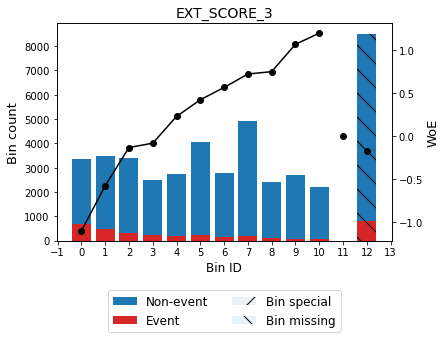

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.23)",3370,0.078277,2665,705,0.209199,-1.101953,0.149161,0.017756
1,"[0.23, 0.33)",3485,0.080949,3013,472,0.135438,-0.578002,0.034434,0.004245
2,"[0.33, 0.40)",3404,0.079067,3093,311,0.091363,-0.134611,0.001516,0.000189
3,"[0.40, 0.45)",2477,0.057535,2261,216,0.087202,-0.083431,0.000415,0.000052
4,"[0.45, 0.51)",2750,0.063876,2570,180,0.065455,0.226989,0.002993,0.000373
5,"[0.51, 0.57)",4051,0.094096,3830,221,0.054554,0.420742,0.013985,0.001735
6,"[0.57, 0.62)",2791,0.064829,2658,133,0.047653,0.563265,0.016292,0.002010
7,"[0.62, 0.69)",4923,0.114350,4721,202,0.041032,0.719793,0.044063,0.005392
8,"[0.69, 0.72)",2402,0.055793,2306,96,0.039967,0.747207,0.022916,0.002800
9,"[0.72, 0.77)",2685,0.062366,2606,79,0.029423,1.064409,0.045916,0.005483


['(-inf, 0.23)',
 '[0.23, 0.33)',
 '[0.33, 0.40)',
 '[0.40, 0.45)',
 '[0.45, 0.51)',
 '[0.51, 0.57)',
 '[0.57, 0.62)',
 '[0.62, 0.69)',
 '[0.69, 0.72)',
 '[0.72, 0.77)',
 '[0.77, inf)',
 'Special',
 'Missing',
 '']

==
terms_payment


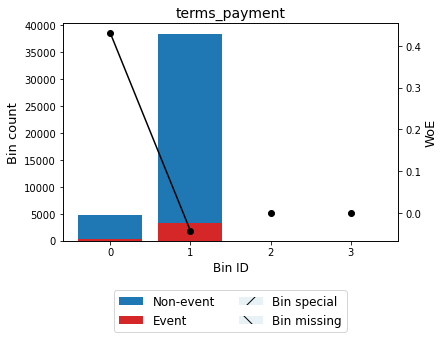

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10.84)",4679,0.108683,4426,253,0.054071,0.430147,0.016818,0.002086
1,"[10.84, inf)",38372,0.891294,35147,3225,0.084046,-0.043109,0.001687,0.000211
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,1,0.000023,1,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.018505,0.002297


['(-inf, 10.84)', '[10.84, inf)', 'Special', 'Missing', '']

==
credit_per_income


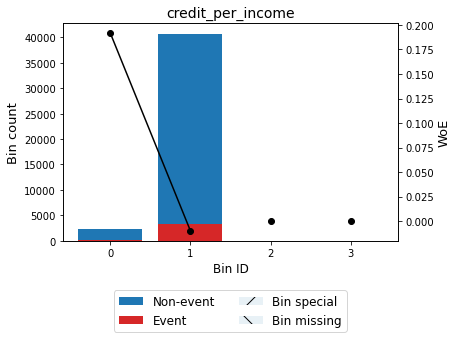

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.00)",2306,0.053563,2150,156,0.067650,0.191652,0.001816,0.000227
1,"[1.00, inf)",40746,0.946437,37424,3322,0.081529,-0.00997,0.000094,0.000012
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.001910,0.000238


['(-inf, 1.00)', '[1.00, inf)', 'Special', 'Missing', '']

==
Approved


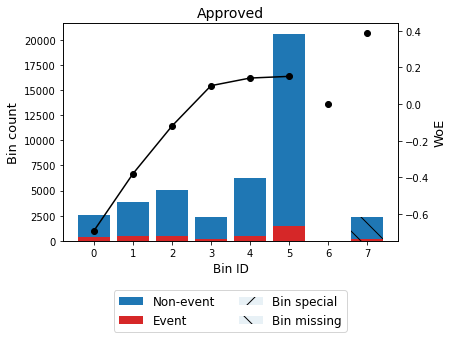

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.31)",2595,0.060276,2207,388,0.149518,-0.693331,0.038681,0.004740
1,"[0.31, 0.45)",3806,0.088405,3372,434,0.114030,-0.381498,0.015099,0.001876
2,"[0.45, 0.57)",5099,0.118438,4639,460,0.090214,-0.120687,0.001815,0.000227
3,"[0.57, 0.63)",2335,0.054237,2163,172,0.073662,0.100042,0.000521,0.000065
4,"[0.63, 0.77)",6251,0.145197,5808,443,0.070869,0.141707,0.002748,0.000343
5,"[0.77, inf)",20622,0.479002,19173,1449,0.070265,0.150914,0.010242,0.001279
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,2344,0.054446,2212,132,0.056314,0.387136,0.006946,0.000863
Totals,,43052,1.000000,39574,3478,0.080786,,0.076050,0.009393


['(-inf, 0.31)',
 '[0.31, 0.45)',
 '[0.45, 0.57)',
 '[0.57, 0.63)',
 '[0.63, 0.77)',
 '[0.77, inf)',
 'Special',
 'Missing',
 '']

==
Refused


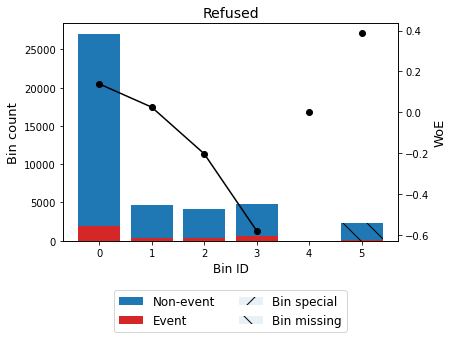

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.09)",27052,0.628356,25130,1922,0.071048,0.138981,0.011452,0.001430
1,"[0.09, 0.23)",4713,0.109472,4341,372,0.078931,0.025251,0.000069,0.000009
2,"[0.23, 0.35)",4178,0.097045,3772,406,0.097176,-0.202707,0.004342,0.000542
3,"[0.35, inf)",4765,0.110680,4119,646,0.135572,-0.579149,0.047291,0.005830
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,2344,0.054446,2212,132,0.056314,0.387136,0.006946,0.000863
Totals,,43052,1.000000,39574,3478,0.080786,,0.070099,0.008674


['(-inf, 0.09)',
 '[0.09, 0.23)',
 '[0.23, 0.35)',
 '[0.35, inf)',
 'Special',
 'Missing',
 '']

==
Unused offer


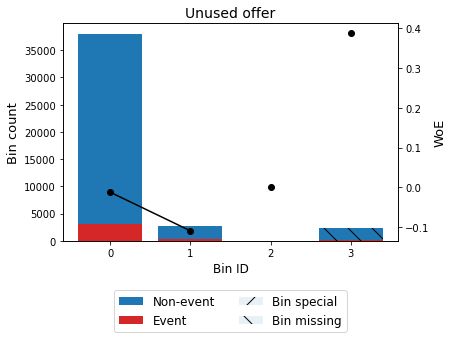

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.05)",38053,0.883885,34944,3109,0.081702,-0.012269,0.000134,0.000017
1,"[0.05, inf)",2655,0.061670,2418,237,0.089266,-0.109079,0.000768,0.000096
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,2344,0.054446,2212,132,0.056314,0.387136,0.006946,0.000863
Totals,,43052,1.000000,39574,3478,0.080786,,0.007848,0.000976


['(-inf, 0.05)', '[0.05, inf)', 'Special', 'Missing', '']

==
overdue_days


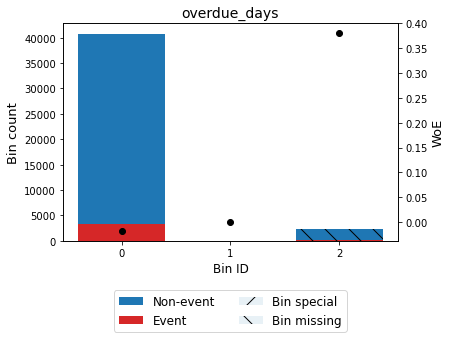

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",40809,0.947900,37458,3351,0.082114,-0.017753,0.000301,0.000038
1,Special,2,0.000046,2,0,0.000000,0.0,0.000000,0.000000
2,Missing,2241,0.052053,2114,127,0.056671,0.380435,0.006431,0.000799
Totals,,43052,1.000000,39574,3478,0.080786,,0.006732,0.000837


['(-inf, inf)', 'Special', 'Missing', '']

==
overdue_amt


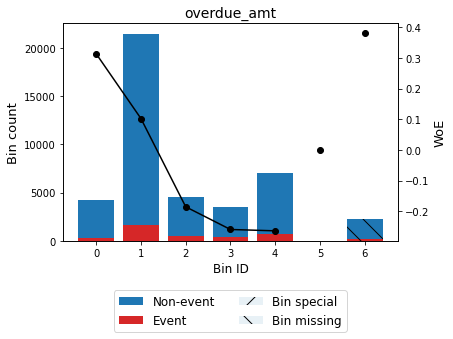

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -18764.75)",4240,0.098486,3984,256,0.060377,0.313149,0.008476,0.001055
1,"[-18764.75, 1936.53)",21490,0.499164,19910,1580,0.073523,0.102082,0.004984,0.000623
2,"[1936.53, 14434.22)",4588,0.106569,4149,439,0.095684,-0.185592,0.003968,0.000495
3,"[14434.22, 32268.13)",3471,0.080623,3116,355,0.102276,-0.259527,0.006055,0.000755
4,"[32268.13, inf)",7022,0.163105,6301,721,0.102677,-0.26389,0.012688,0.001581
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,2241,0.052053,2114,127,0.056671,0.380435,0.006431,0.000799
Totals,,43052,1.000000,39574,3478,0.080786,,0.042602,0.005308


['(-inf, -18764.75)',
 '[-18764.75, 1936.53)',
 '[1936.53, 14434.22)',
 '[14434.22, 32268.13)',
 '[32268.13, inf)',
 'Special',
 'Missing',
 '']

==
has_overdue_day


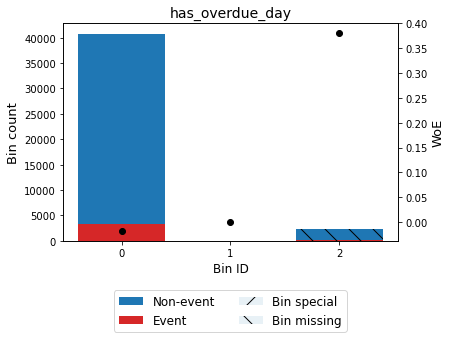

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",40811,0.947947,37460,3351,0.082110,-0.0177,0.000299,0.000037
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,2241,0.052053,2114,127,0.056671,0.380435,0.006431,0.000799
Totals,,43052,1.000000,39574,3478,0.080786,,0.006730,0.000836


['(-inf, inf)', 'Special', 'Missing', '']

==
has_overdue_amt


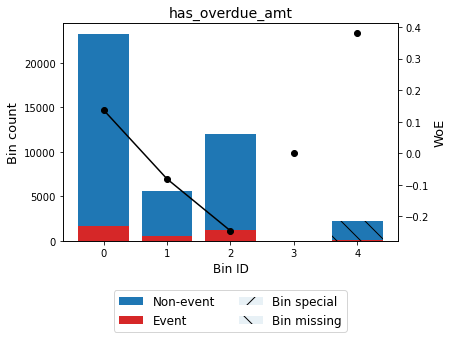

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",23261,0.540300,21605,1656,0.071192,0.136805,0.009549,0.001193
1,"[0.50, 2.50)",5583,0.129680,5097,486,0.087050,-0.081516,0.000892,0.000111
2,"[2.50, inf)",11967,0.277966,10758,1209,0.101028,-0.245859,0.018628,0.002323
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,2241,0.052053,2114,127,0.056671,0.380435,0.006431,0.000799
Totals,,43052,1.000000,39574,3478,0.080786,,0.035500,0.004426


['(-inf, 0.50)', '[0.50, 2.50)', '[2.50, inf)', 'Special', 'Missing', '']

==
insure_rate


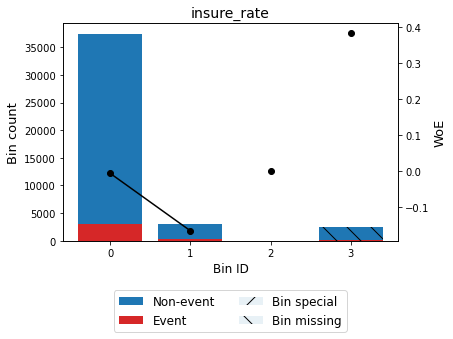

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.90)",37467,0.870273,34420,3047,0.081325,-0.007235,0.000046,0.000006
1,"[0.90, inf)",3071,0.071332,2782,289,0.094106,-0.167216,0.002140,0.000267
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,2514,0.058394,2372,142,0.056484,0.383947,0.007337,0.000912
Totals,,43052,1.000000,39574,3478,0.080786,,0.009523,0.001184


['(-inf, 0.90)', '[0.90, inf)', 'Special', 'Missing', '']

==
year_age


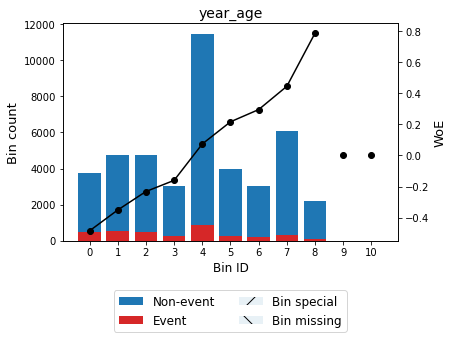

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 27.77)",3772,0.087615,3301,471,0.124867,-0.484592,0.025203,0.003120
1,"[27.77, 31.98)",4732,0.109914,4207,525,0.110947,-0.350608,0.015652,0.001947
2,"[31.98, 36.33)",4752,0.110378,4278,474,0.099747,-0.231681,0.006530,0.000814
3,"[36.33, 38.77)",3059,0.071054,2773,286,0.093495,-0.160022,0.001946,0.000243
4,"[38.77, 49.24)",11477,0.266585,10611,866,0.075455,0.074047,0.001417,0.000177
5,"[49.24, 53.43)",3964,0.092075,3702,262,0.066095,0.216569,0.003945,0.000492
6,"[53.43, 56.51)",3029,0.070357,2843,186,0.061406,0.295154,0.005419,0.000675
7,"[56.51, 63.51)",6058,0.140714,5735,323,0.053318,0.444976,0.023161,0.002871
8,"[63.51, inf)",2209,0.051310,2124,85,0.038479,0.78669,0.022997,0.002803
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, 27.77)',
 '[27.77, 31.98)',
 '[31.98, 36.33)',
 '[36.33, 38.77)',
 '[38.77, 49.24)',
 '[49.24, 53.43)',
 '[53.43, 56.51)',
 '[56.51, 63.51)',
 '[63.51, inf)',
 'Special',
 'Missing',
 '']

==
year_work


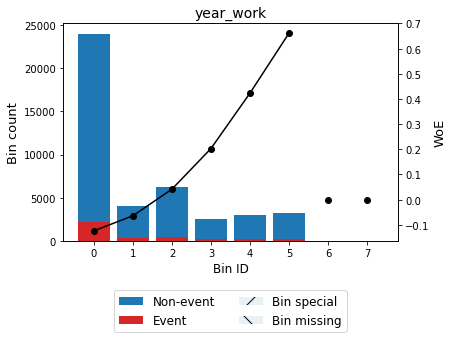

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.05)",24028,0.558116,21854,2174,0.090478,-0.1239,0.009025,0.001127
1,"[4.05, 5.49)",4062,0.094351,3714,348,0.085672,-0.064053,0.000398,0.000050
2,"[5.49, 8.80)",6277,0.145800,5789,488,0.077744,0.041685,0.000249,0.000031
3,"[8.80, 10.89)",2495,0.057953,2328,167,0.066934,0.203056,0.002195,0.000274
4,"[10.89, 14.90)",2940,0.068290,2780,160,0.054422,0.423317,0.010263,0.001273
5,"[14.90, inf)",3250,0.075490,3109,141,0.043385,0.661582,0.025154,0.003088
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,43052,1.000000,39574,3478,0.080786,,0.047284,0.005844


['(-inf, 4.05)',
 '[4.05, 5.49)',
 '[5.49, 8.80)',
 '[8.80, 10.89)',
 '[10.89, 14.90)',
 '[14.90, inf)',
 'Special',
 'Missing',
 '']

==


In [37]:
bfp['NUM_CHILDREN']['monotonic_trend']='ascending'
bfp['credit_per_income']['monotonic_trend']='ascending'
bfp['overdue_days']['monotonic_trend']='ascending'
bfp['overdue_amt']['monotonic_trend']='ascending'
bfp['has_overdue_day']['monotonic_trend']='ascending'
bfp['has_overdue_amt']['monotonic_trend']='ascending'

bfp['INCOME']['monotonic_trend']='descending'
bfp['APPROVED_CREDIT']['monotonic_trend']='descending'
bfp['year_work']['monotonic_trend']='descending'
bfp['year_age']['monotonic_trend']='descending'


bfp['insure_rate']['monotonic_trend']='auto_asc_desc'

bfp['INCOME_TYPE']['user_splits']=user_split_income_type
bfp['INCOME_TYPE']['user_splits_fixed']=user_split_income_fixed



binning_process = create_binning(train, bfp)

In [38]:
get_iv(binning_process)

,column,IV,predictiveness
14,EXT_SCORE_3,0.383135,Strong predictive Power
13,EXT_SCORE_2,0.324745,Strong predictive Power
12,EXT_SCORE_1,0.192043,Medium predictive Power
25,year_age,0.106269,Medium predictive Power
11,ORGANIZATION_TYPE,0.088333,Weak predictive Power
17,Approved,0.076050,Weak predictive Power
18,Refused,0.070099,Weak predictive Power
5,INCOME_TYPE,0.068895,Weak predictive Power
6,EDUCATION,0.061190,Weak predictive Power
10,DAYS_ID_CHANGE,0.047378,Weak predictive Power


In [39]:
df_train_binned = binning_process.transform(train.drop(columns=['TARGET']))

In [40]:
class_weight=get_class_weight(train)
class_weight

{0: 0.3565517129245728, 1: 0.9434499130123734}

In [41]:
y_train = train.TARGET
y_valid = valid.TARGET
X_train = binning_process.transform(train.drop(columns=['TARGET']))
X_valid = binning_process.transform(valid.drop(columns=['TARGET']))

lr = LogisticRegression( n_jobs=-1,
                        class_weight=class_weight
                        # class_weight='balanced'
                       )
lr.fit(X_train, y_train)
train_proba = lr.predict_proba(X_train)[:,1]
train_pred = lr.predict(X_train)
valid_pred = lr.predict(X_valid)
valid_proba = lr.predict_proba(X_valid)[:,1]

# performance on train set

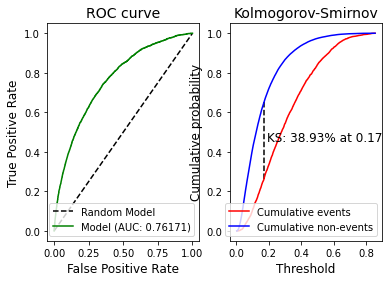

In [42]:
plt.subplot(1, 2, 1)
plot_auc_roc(y_train, train_proba)
plt.subplot(1, 2, 2)
plot_ks(y_train, train_proba)

precision=0.64116177159264
recall=0.5671622372865613
fscore=0.5858189629207575


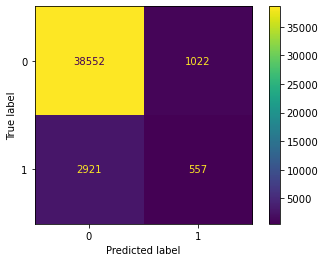

In [43]:
precision, recall, fscore, support = precision_recall_fscore_support(y_train, train_pred, average='macro')
print(f"""{precision=}
{recall=}
{fscore=}""")
ConfusionMatrixDisplay.from_estimator(lr,X_train,y_train)

# performance on validation set

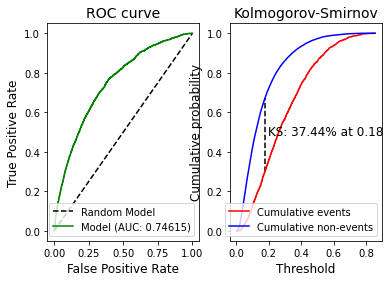

In [45]:
plt.subplot(1, 2, 1)
plot_auc_roc(y_valid, valid_proba)
plt.subplot(1, 2, 2)
plot_ks(y_valid, valid_proba)

precision=0.6209965224489031
recall=0.5571670787302431
fscore=0.572491407658061


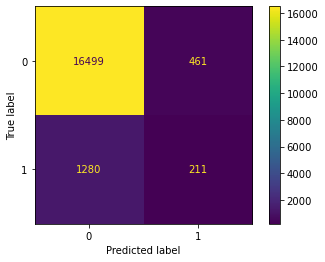

In [46]:
precision, recall, fscore, support = precision_recall_fscore_support(y_valid, valid_pred, average='macro')
print(f"""{precision=}
{recall=}
{fscore=}""")
ConfusionMatrixDisplay.from_estimator(lr,X_valid,y_valid)

# prediction on real test dataset

## binning with full dataset

((61503, 28), (14761, 28))

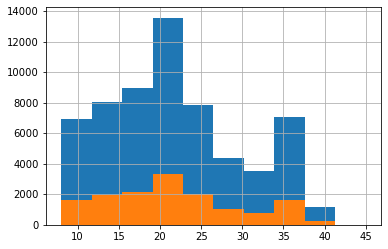

In [47]:
engineered_train = generate_dataset(df, dfprev,dfinst)

In [81]:

binning_process_full = create_binning(engineered_train, bfp,plot=False)
get_iv(binning_process_full)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,column,IV,predictiveness
10,EXT_SCORE_3,0.351570,Strong predictive Power
9,EXT_SCORE_2,0.319735,Strong predictive Power
8,EXT_SCORE_1,0.190283,Medium predictive Power
16,year_age,0.104809,Medium predictive Power
7,ORGANIZATION_TYPE,0.087203,Weak predictive Power
12,Approved,0.070149,Weak predictive Power
2,INCOME_TYPE,0.068243,Weak predictive Power
13,Refused,0.063574,Weak predictive Power
3,EDUCATION,0.058582,Weak predictive Power
6,DAYS_ID_CHANGE,0.048173,Weak predictive Power


((61503, 28), (14761, 28))

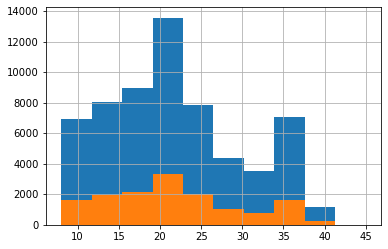

In [90]:
drop_cols=[
    'LN_ID','Unnamed: 0', 'SK_ID_PREV', 'HOUR_APPLY','WEEKDAYS_APPLY','PRICE','ANNUITY','Canceled',
    # 'INCOME','CONTRACT_TYPE','HOUSING_TYPE','insure_rate','NUM_CHILDREN','Unused offer','overdue_days','has_overdue_day','credit_per_income'
]

engineered_train = generate_dataset(
    df, dfprev,dfinst,
    drop_cols=drop_cols
)
engineered_test = generate_dataset(
    dftest, dfprev,dfinst,
    drop_cols=drop_cols
)
engineered_train.shape, engineered_test.shape

d:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


CONTRACT_TYPE


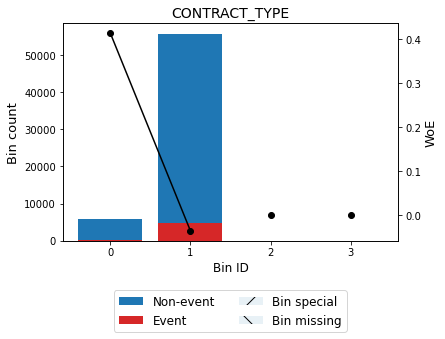

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Revolving loans],5804,0.094369,5485,319,0.054962,0.412958,0.013555,0.001682
1,[Cash loans],55699,0.905631,51049,4650,0.083484,-0.035705,0.001172,0.000146
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.014727,0.001829


[array(['Revolving loans'], dtype=object),
 array(['Cash loans'], dtype=object),
 'Special',
 'Missing',
 '']

==
GENDER


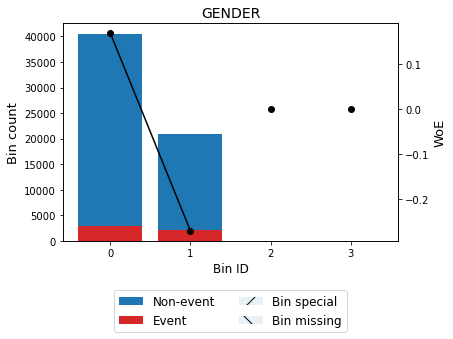

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[F],40549,0.659301,37745,2804,0.069151,0.168182,0.017382,0.002170
1,[M],20954,0.340699,18789,2165,0.103322,-0.270772,0.027985,0.003487
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.045367,0.005658


[array(['F'], dtype=object),
 array(['M'], dtype=object),
 'Special',
 'Missing',
 '']

==
NUM_CHILDREN


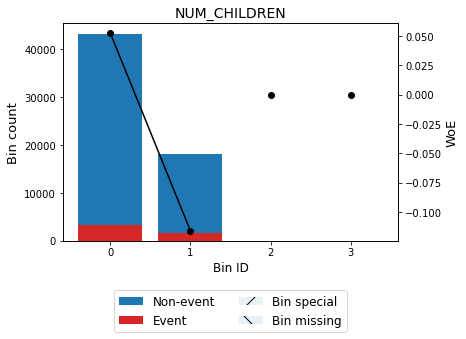

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",43295,0.703949,39962,3333,0.076983,0.052433,0.001893,0.000237
1,"[0.50, inf)",18208,0.296051,16572,1636,0.089851,-0.116163,0.004194,0.000524
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.006088,0.000761


['(-inf, 0.50)', '[0.50, inf)', 'Special', 'Missing', '']

==
INCOME


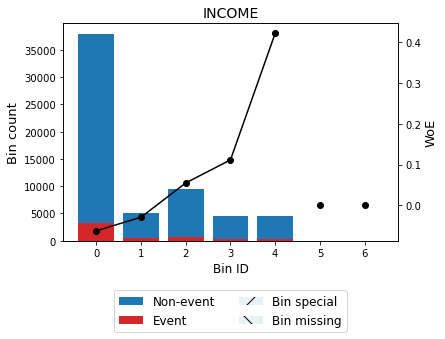

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 177599.25)",37982,0.617563,34731,3251,0.085593,-0.062954,0.002513,0.000314
1,"[177599.25, 180045.00)",4999,0.081281,4584,415,0.083017,-0.029575,0.000072,0.000009
2,"[180045.00, 247050.00)",9463,0.153862,8736,727,0.076826,0.054658,0.000449,0.000056
3,"[247050.00, 297675.00)",4486,0.072940,4159,327,0.072893,0.111446,0.000865,0.000108
4,"[297675.00, inf)",4573,0.074354,4324,249,0.054450,0.42286,0.011153,0.001384
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.015051,0.001871


['(-inf, 177599.25)',
 '[177599.25, 180045.00)',
 '[180045.00, 247050.00)',
 '[247050.00, 297675.00)',
 '[297675.00, inf)',
 'Special',
 'Missing',
 '']

==
APPROVED_CREDIT


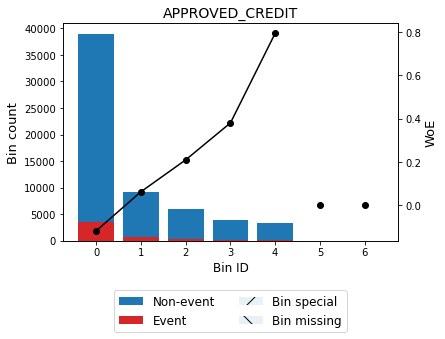

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 668394.00)",39014,0.634343,35499,3515,0.090096,-0.119159,0.009469,0.001183
1,"[668394.00, 881165.25)",9237,0.150188,8532,705,0.076323,0.061758,0.000558,0.000070
2,"[881165.25, 1110537.00)",6041,0.098223,5639,402,0.066545,0.209386,0.003946,0.000492
3,"[1110537.00, 1345173.75)",3882,0.063119,3662,220,0.056672,0.380514,0.007801,0.000969
4,"[1345173.75, inf)",3329,0.054127,3202,127,0.038150,0.79572,0.024731,0.003012
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.046504,0.005727


['(-inf, 668394.00)',
 '[668394.00, 881165.25)',
 '[881165.25, 1110537.00)',
 '[1110537.00, 1345173.75)',
 '[1345173.75, inf)',
 'Special',
 'Missing',
 '']

==
INCOME_TYPE


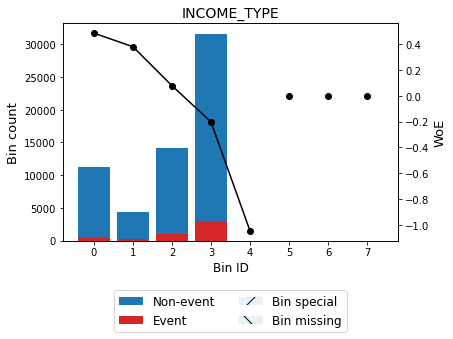

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Student, Pensioner]",11252,0.182950,10674,578,0.051369,0.484369,0.035110,0.004346
1,[State servant],4407,0.071655,4157,250,0.056728,0.379464,0.008811,0.001095
2,[Commercial associate],14217,0.231159,13148,1069,0.075192,0.077922,0.001359,0.000170
3,[Working],31621,0.514138,28550,3071,0.097119,-0.20197,0.022828,0.002849
4,[Unemployed],5,0.000081,4,1,0.200000,-1.045329,0.000136,0.000016
5,[Businessman],1,0.000016,1,0,0.000000,0.0,0.000000,0.000000
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.068243,0.008476


[['Student', 'Pensioner'],
 ['State servant'],
 ['Commercial associate'],
 ['Working'],
 ['Unemployed'],
 array(['Businessman'], dtype='<U11'),
 'Special',
 'Missing',
 '']

==
EDUCATION


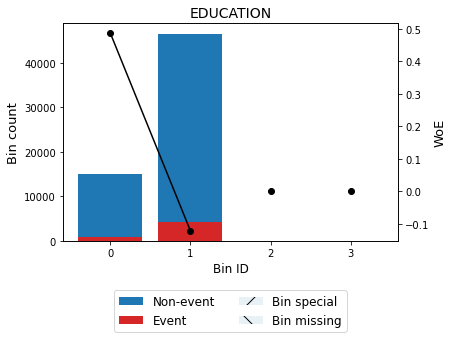

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Academic degree, Higher education]",14921,0.242606,14156,765,0.051270,0.486394,0.046910,0.005807
1,"[Incomplete higher, Secondary / secondary spec...",46582,0.757394,42378,4204,0.090249,-0.121031,0.011673,0.001458
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.058582,0.007265


[array(['Academic degree', 'Higher education'], dtype=object),
 array(['Incomplete higher', 'Secondary / secondary special',
        'Lower secondary'], dtype=object),
 'Special',
 'Missing',
 '']

==
FAMILY_STATUS


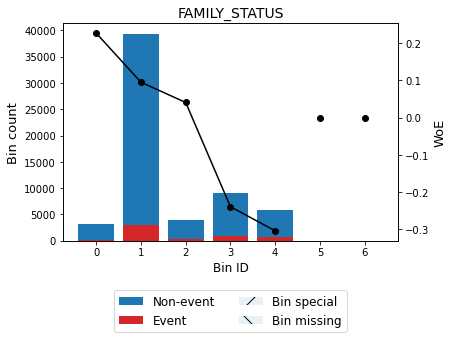

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Widow],3253,0.052892,3040,213,0.065478,0.226697,0.002473,0.000308
1,[Married],39370,0.640131,36456,2914,0.074016,0.094956,0.005547,0.000693
2,[Separated],3970,0.064550,3661,309,0.077834,0.040527,0.000104,0.000013
3,[Single / not married],9029,0.146806,8122,907,0.100454,-0.239434,0.009306,0.001160
4,[Civil marriage],5881,0.095621,5255,626,0.106444,-0.304039,0.010042,0.001250
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.027471,0.003425


[array(['Widow'], dtype=object),
 array(['Married'], dtype=object),
 array(['Separated'], dtype=object),
 array(['Single / not married'], dtype=object),
 array(['Civil marriage'], dtype=object),
 'Special',
 'Missing',
 '']

==
HOUSING_TYPE


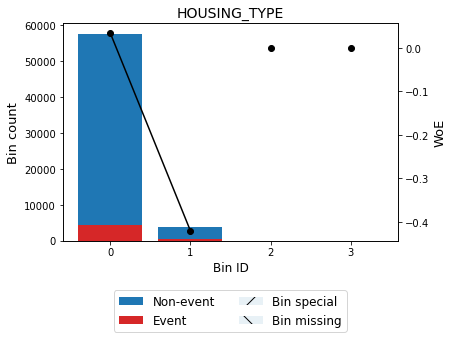

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Office apartment, Co-op apartment, House / ap...",57624,0.93693,53113,4511,0.078283,0.034279,0.001085,0.000136
1,"[With parents, Rented apartment]",3879,0.06307,3421,458,0.118072,-0.420805,0.013322,0.001653
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.00000,56534,4969,0.080793,,0.014408,0.001789


[array(['Office apartment', 'Co-op apartment', 'House / apartment',
        'Municipal apartment'], dtype=object),
 array(['With parents', 'Rented apartment'], dtype=object),
 'Special',
 'Missing',
 '']

==
DAYS_REGISTRATION


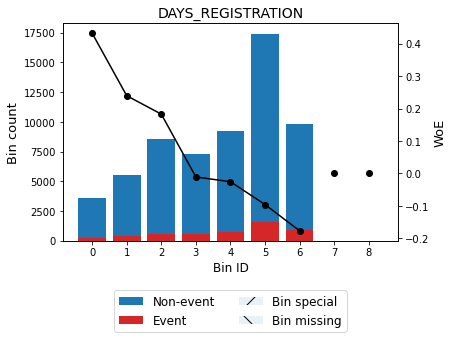

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -11003.50)",3632,0.059054,3436,196,0.053965,0.432325,0.009223,0.001144
1,"[-11003.50, -9034.50)",5502,0.089459,5146,356,0.064704,0.239421,0.004640,0.000579
2,"[-9034.50, -6954.50)",8545,0.138936,7962,583,0.068227,0.182625,0.004293,0.000536
3,"[-6954.50, -5379.50)",7302,0.118726,6706,596,0.081621,-0.011106,0.000015,0.000002
4,"[-5379.50, -4002.50)",9247,0.150350,8482,765,0.082730,-0.025798,0.000101,0.000013
5,"[-4002.50, -1119.50)",17419,0.283222,15882,1537,0.088237,-0.09627,0.002733,0.000341
6,"[-1119.50, inf)",9856,0.160252,8920,936,0.094968,-0.177188,0.005420,0.000677
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.026425,0.003291


['(-inf, -11003.50)',
 '[-11003.50, -9034.50)',
 '[-9034.50, -6954.50)',
 '[-6954.50, -5379.50)',
 '[-5379.50, -4002.50)',
 '[-4002.50, -1119.50)',
 '[-1119.50, inf)',
 'Special',
 'Missing',
 '']

==
DAYS_ID_CHANGE


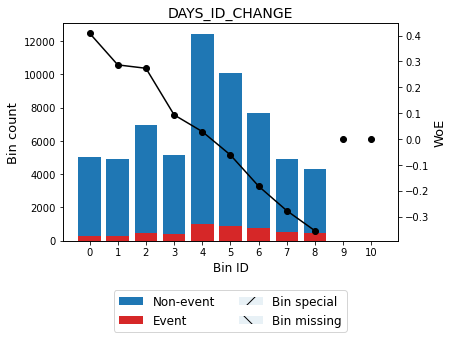

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -4795.50)",5040,0.081947,4762,278,0.055159,0.409178,0.011574,0.001437
1,"[-4795.50, -4537.50)",4894,0.079573,4591,303,0.061913,0.286497,0.005796,0.000722
2,"[-4537.50, -4241.50)",6940,0.112840,6505,435,0.062680,0.273357,0.007523,0.000937
3,"[-4241.50, -4031.50)",5139,0.083557,4758,381,0.074139,0.09316,0.000697,0.000087
4,"[-4031.50, -2889.50)",12439,0.202250,11460,979,0.078704,0.028463,0.000162,0.000020
5,"[-2889.50, -1882.50)",10090,0.164057,9227,863,0.085530,-0.062149,0.000650,0.000081
6,"[-1882.50, -1059.50)",7700,0.125197,6965,735,0.095455,-0.182841,0.004519,0.000564
7,"[-1059.50, -516.50)",4935,0.080240,4422,513,0.103951,-0.277552,0.006945,0.000865
8,"[-516.50, inf)",4326,0.070338,3844,482,0.111419,-0.355299,0.010306,0.001282
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, -4795.50)',
 '[-4795.50, -4537.50)',
 '[-4537.50, -4241.50)',
 '[-4241.50, -4031.50)',
 '[-4031.50, -2889.50)',
 '[-2889.50, -1882.50)',
 '[-1882.50, -1059.50)',
 '[-1059.50, -516.50)',
 '[-516.50, inf)',
 'Special',
 'Missing',
 '']

==
ORGANIZATION_TYPE


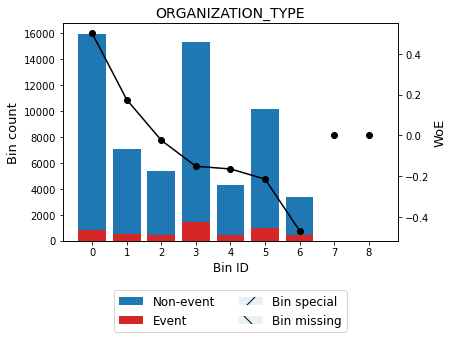

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Trade: type 5, Industry: type 12, Insurance, ...",15932,0.259044,15127,805,0.050527,0.501771,0.052971,0.006553
1,"[Industry: type 11, Telecom, Government, Medic...",7062,0.114824,6577,485,0.068677,0.175561,0.003289,0.000411
2,"[Kindergarten, Electricity, Hotel, Services, O...",5388,0.087605,4943,445,0.082591,-0.02397,0.000051,0.000006
3,"[Culture, Business Entity Type 1, Business Ent...",15317,0.249045,13896,1421,0.092773,-0.151383,0.006082,0.000759
4,"[Trade: type 3, Business Entity Type 2, Trade:...",4303,0.069964,3899,404,0.093888,-0.164563,0.002030,0.000253
5,"[Security, Self-employed, Industry: type 2, Tr...",10162,0.165228,9164,998,0.098209,-0.214339,0.008305,0.001036
6,"[Legal Services, Realtor, Advertising, Industr...",3339,0.054290,2928,411,0.123091,-0.468142,0.014475,0.001793
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.087203,0.010812


[array(['Trade: type 5', 'Industry: type 12', 'Insurance', 'Bank',
        'Military', 'Industry: type 6', 'Trade: type 6',
        'Transport: type 1', 'Security Ministries', 'Police', 'Emergency',
        'University', 'NA1', 'School', 'Industry: type 5',
        'Industry: type 13'], dtype=object),
 array(['Industry: type 11', 'Telecom', 'Government', 'Medicine',
        'Trade: type 2', 'Transport: type 2', 'Trade: type 4',
        'Industry: type 9', 'Industry: type 7', 'Postal'], dtype=object),
 array(['Kindergarten', 'Electricity', 'Hotel', 'Services', 'Other'],
       dtype=object),
 array(['Culture', 'Business Entity Type 1', 'Business Entity Type 3',
        'Agriculture'], dtype=object),
 array(['Trade: type 3', 'Business Entity Type 2', 'Trade: type 7'],
       dtype=object),
 array(['Security', 'Self-employed', 'Industry: type 2',
        'Transport: type 4', 'Trade: type 1', 'Housing', 'Mobile'],
       dtype=object),
 array(['Legal Services', 'Realtor', 'Advertising', 'I

==
EXT_SCORE_1


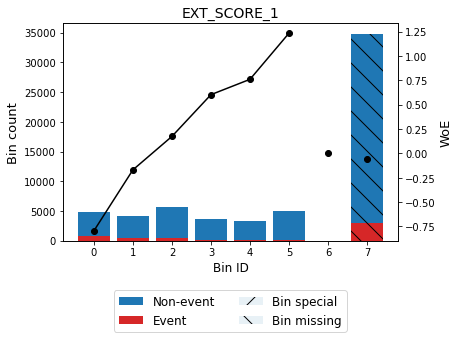

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.28)",4786,0.077817,4006,780,0.162975,-0.795369,0.068492,0.008343
1,"[0.28, 0.40)",4169,0.067785,3776,393,0.094267,-0.169013,0.002079,0.000260
2,"[0.40, 0.54)",5745,0.093410,5350,395,0.068755,0.174342,0.002640,0.000330
3,"[0.54, 0.63)",3640,0.059184,3473,167,0.045879,0.603157,0.016782,0.002067
4,"[0.63, 0.72)",3345,0.054388,3213,132,0.039462,0.760535,0.023020,0.002810
5,"[0.72, inf)",4973,0.080858,4849,124,0.024935,1.234623,0.075086,0.008832
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,34845,0.566558,31867,2978,0.085464,-0.061305,0.002185,0.000273
Totals,,61503,1.000000,56534,4969,0.080793,,0.190283,0.022913


['(-inf, 0.28)',
 '[0.28, 0.40)',
 '[0.40, 0.54)',
 '[0.54, 0.63)',
 '[0.63, 0.72)',
 '[0.72, inf)',
 'Special',
 'Missing',
 '']

==
EXT_SCORE_2


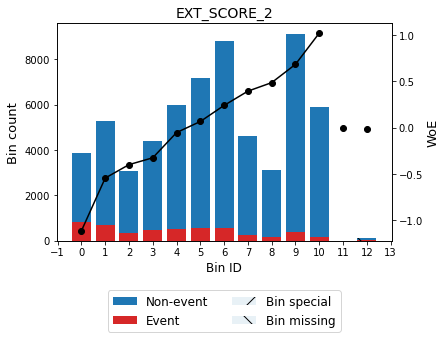

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.16)",3846,0.062534,3032,814,0.211648,-1.116606,1.230324e-01,1.462681e-02
1,"[0.16, 0.28)",5283,0.085898,4587,696,0.131743,-0.545992,3.217607e-02,3.972783e-03
2,"[0.28, 0.34)",3086,0.050176,2728,358,0.116008,-0.400833,9.536826e-03,1.184186e-03
3,"[0.34, 0.41)",4382,0.071249,3906,476,0.108626,-0.326772,8.725723e-03,1.085888e-03
4,"[0.41, 0.49)",5995,0.097475,5486,509,0.084904,-0.054117,2.920231e-04,3.649843e-05
5,"[0.49, 0.56)",7194,0.116970,6647,547,0.076036,0.065848,4.933864e-04,6.166217e-05
6,"[0.56, 0.62)",8826,0.143505,8255,571,0.064695,0.239562,7.451769e-03,9.292502e-04
7,"[0.62, 0.65)",4628,0.075248,4369,259,0.055964,0.393838,9.908078e-03,1.230567e-03
8,"[0.65, 0.67)",3100,0.050404,2941,159,0.051290,0.485977,9.730915e-03,1.204534e-03
9,"[0.67, 0.72)",9131,0.148464,8743,388,0.042493,0.68338,5.232377e-02,6.416102e-03


['(-inf, 0.16)',
 '[0.16, 0.28)',
 '[0.28, 0.34)',
 '[0.34, 0.41)',
 '[0.41, 0.49)',
 '[0.49, 0.56)',
 '[0.56, 0.62)',
 '[0.62, 0.65)',
 '[0.65, 0.67)',
 '[0.67, 0.72)',
 '[0.72, inf)',
 'Special',
 'Missing',
 '']

==
EXT_SCORE_3


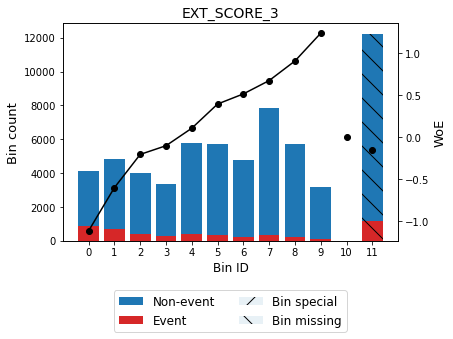

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.21)",4126,0.067086,3252,874,0.211827,-1.117679,0.132297,0.015727
1,"[0.21, 0.31)",4810,0.078208,4144,666,0.138462,-0.603497,0.036650,0.004513
2,"[0.31, 0.38)",4004,0.065103,3613,391,0.097652,-0.208037,0.003075,0.000384
3,"[0.38, 0.43)",3363,0.054680,3064,299,0.088909,-0.104591,0.000625,0.000078
4,"[0.43, 0.51)",5748,0.093459,5326,422,0.073417,0.103727,0.000963,0.000120
5,"[0.51, 0.57)",5725,0.093085,5404,321,0.056070,0.39183,0.012142,0.001508
6,"[0.57, 0.62)",4798,0.078012,4558,240,0.050021,0.512377,0.016562,0.002048
7,"[0.62, 0.70)",7815,0.127067,7479,336,0.042994,0.67112,0.043403,0.005326
8,"[0.70, 0.77)",5704,0.092743,5508,196,0.034362,0.904219,0.052430,0.006339
9,"[0.77, inf)",3171,0.051558,3092,79,0.024913,1.235502,0.047930,0.005637


['(-inf, 0.21)',
 '[0.21, 0.31)',
 '[0.31, 0.38)',
 '[0.38, 0.43)',
 '[0.43, 0.51)',
 '[0.51, 0.57)',
 '[0.57, 0.62)',
 '[0.62, 0.70)',
 '[0.70, 0.77)',
 '[0.77, inf)',
 'Special',
 'Missing',
 '']

==
terms_payment


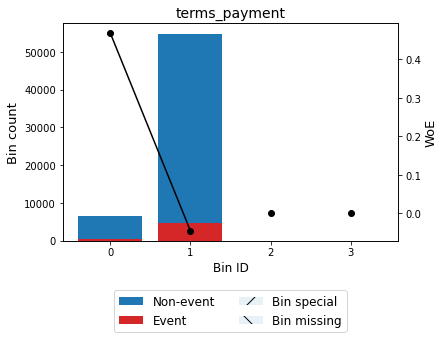

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10.82)",6652,0.108157,6305,347,0.052165,0.46815,0.019518,0.002418
1,"[10.82, inf)",54850,0.891826,50228,4622,0.084266,-0.045878,0.001914,0.000239
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,1,0.000016,1,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.021432,0.002657


['(-inf, 10.82)', '[10.82, inf)', 'Special', 'Missing', '']

==
credit_per_income


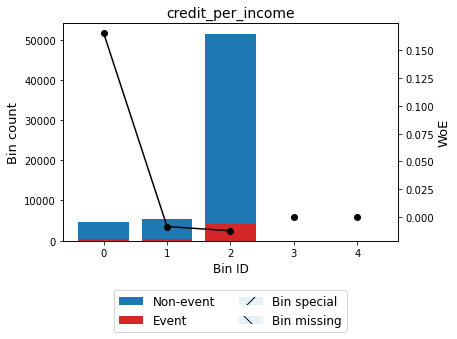

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.15)",4544,0.073883,4229,315,0.069322,0.165525,0.001889,2.358414e-04
1,"[1.15, 1.64)",5476,0.089036,5030,446,0.081446,-0.008767,0.000007,8.586262e-07
2,"[1.64, inf)",51483,0.837081,47275,4208,0.081736,-0.012629,0.000134,1.677818e-05
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,61503,1.000000,56534,4969,0.080793,,0.002030,2.534782e-04


['(-inf, 1.15)', '[1.15, 1.64)', '[1.64, inf)', 'Special', 'Missing', '']

==
Approved


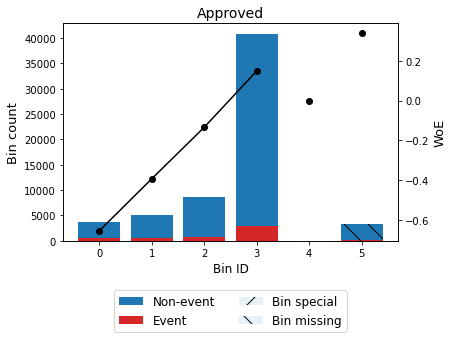

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.31)",3606,0.058631,3084,522,0.144759,-0.655308,0.033093,0.004064
1,"[0.31, 0.43)",5093,0.082809,4506,587,0.115256,-0.393483,0.015121,0.001878
2,"[0.43, 0.59)",8637,0.140432,7848,789,0.091351,-0.134376,0.002683,0.000335
3,"[0.59, inf)",40841,0.664049,37966,2875,0.070395,0.149015,0.013854,0.001730
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,3326,0.054079,3130,196,0.058930,0.33905,0.005398,0.000672
Totals,,61503,1.000000,56534,4969,0.080793,,0.070149,0.008679


['(-inf, 0.31)',
 '[0.31, 0.43)',
 '[0.43, 0.59)',
 '[0.59, inf)',
 'Special',
 'Missing',
 '']

==
Refused


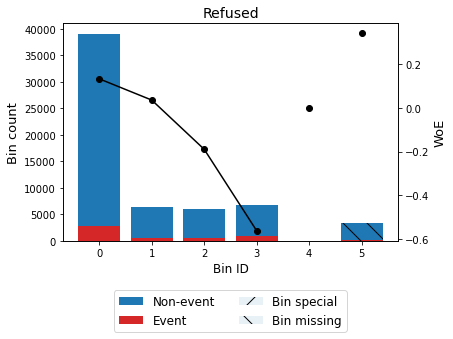

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.10)",39088,0.635546,36290,2798,0.071582,0.131014,0.010327,0.001290
1,"[0.10, 0.23)",6349,0.103231,5852,497,0.078280,0.034325,0.000120,0.000015
2,"[0.23, 0.35)",5944,0.096646,5373,571,0.096063,-0.189871,0.003773,0.000471
3,"[0.35, inf)",6796,0.110499,5889,907,0.133461,-0.560925,0.043956,0.005424
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,3326,0.054079,3130,196,0.058930,0.33905,0.005398,0.000672
Totals,,61503,1.000000,56534,4969,0.080793,,0.063574,0.007871


['(-inf, 0.10)',
 '[0.10, 0.23)',
 '[0.23, 0.35)',
 '[0.35, inf)',
 'Special',
 'Missing',
 '']

==
Unused offer


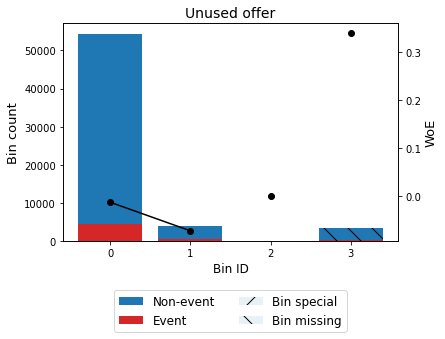

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.05)",54435,0.885079,49985,4450,0.081749,-0.012805,0.000146,0.000018
1,"[0.05, inf)",3742,0.060843,3419,323,0.086317,-0.072173,0.000327,0.000041
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,3326,0.054079,3130,196,0.058930,0.33905,0.005398,0.000672
Totals,,61503,1.000000,56534,4969,0.080793,,0.005870,0.000731


['(-inf, 0.05)', '[0.05, inf)', 'Special', 'Missing', '']

==
overdue_days


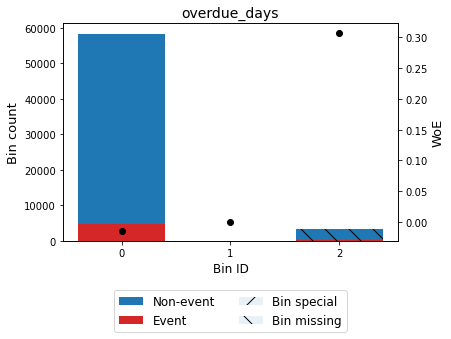

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",58307,0.948035,53532,4775,0.081894,-0.014738,0.000207,0.000026
1,Special,2,0.000033,2,0,0.000000,0.0,0.000000,0.000000
2,Missing,3194,0.051932,3000,194,0.060739,0.306886,0.004304,0.000536
Totals,,61503,1.000000,56534,4969,0.080793,,0.004511,0.000562


['(-inf, inf)', 'Special', 'Missing', '']

==
overdue_amt


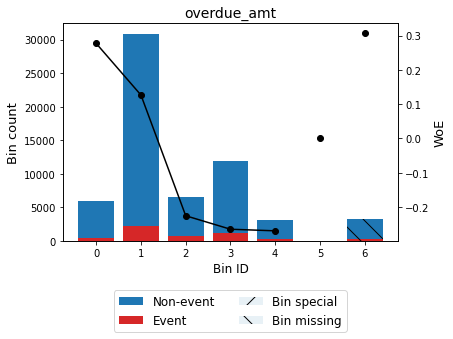

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -18753.75)",5987,0.097345,5613,374,0.062469,0.276961,0.006652,0.000829
1,"[-18753.75, 2241.18)",30883,0.502138,28663,2220,0.071884,0.126476,0.007618,0.000952
2,"[2241.18, 14672.70)",6503,0.105735,5858,645,0.099185,-0.22531,0.005900,0.000736
3,"[14672.70, 126790.18)",11854,0.192739,10636,1218,0.102750,-0.264589,0.015078,0.001879
4,"[126790.18, inf)",3082,0.050111,2764,318,0.103180,-0.269241,0.004067,0.000507
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,3194,0.051932,3000,194,0.060739,0.306886,0.004304,0.000536
Totals,,61503,1.000000,56534,4969,0.080793,,0.043619,0.005438


['(-inf, -18753.75)',
 '[-18753.75, 2241.18)',
 '[2241.18, 14672.70)',
 '[14672.70, 126790.18)',
 '[126790.18, inf)',
 'Special',
 'Missing',
 '']

==
has_overdue_day


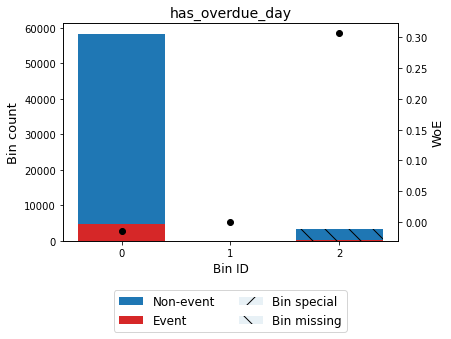

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",58309,0.948068,53534,4775,0.081891,-0.014701,0.000206,0.000026
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,3194,0.051932,3000,194,0.060739,0.306886,0.004304,0.000536
Totals,,61503,1.000000,56534,4969,0.080793,,0.004510,0.000562


['(-inf, inf)', 'Special', 'Missing', '']

==
has_overdue_amt


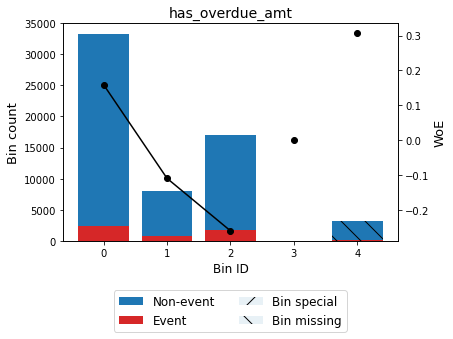

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",33337,0.542039,31012,2325,0.069742,0.159031,0.012826,0.001602
1,"[0.50, 2.50)",7976,0.129685,7264,712,0.089268,-0.109016,0.001613,0.000202
2,"[2.50, inf)",16996,0.276344,15258,1738,0.102259,-0.259255,0.020709,0.002581
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,3194,0.051932,3000,194,0.060739,0.306886,0.004304,0.000536
Totals,,61503,1.000000,56534,4969,0.080793,,0.039452,0.004920


['(-inf, 0.50)', '[0.50, 2.50)', '[2.50, inf)', 'Special', 'Missing', '']

==
insure_rate


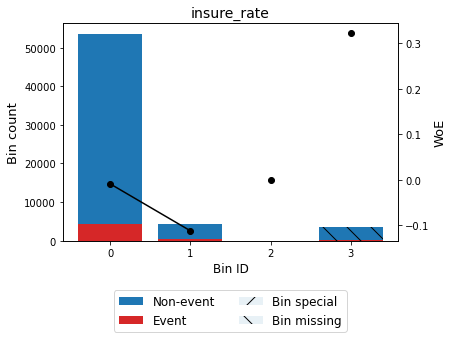

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.90)",53633,0.872039,49263,4370,0.081480,-0.009213,0.000074,0.000009
1,"[0.90, inf)",4311,0.070094,3925,386,0.089538,-0.112339,0.000927,0.000116
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,3559,0.057867,3346,213,0.059848,0.322605,0.005265,0.000655
Totals,,61503,1.000000,56534,4969,0.080793,,0.006266,0.000780


['(-inf, 0.90)', '[0.90, inf)', 'Special', 'Missing', '']

==
year_age


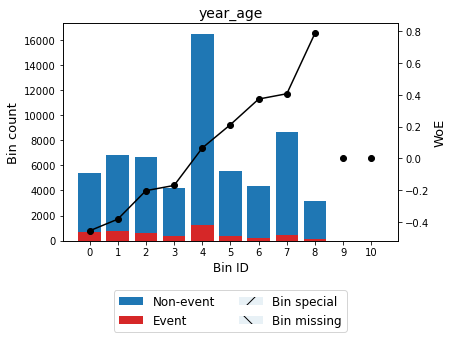

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 27.77)",5418,0.088093,4758,660,0.121816,-0.456281,0.022203,0.002752
1,"[27.77, 32.07)",6857,0.111490,6074,783,0.114190,-0.382984,0.019202,0.002386
2,"[32.07, 36.36)",6663,0.108336,6015,648,0.097253,-0.203503,0.004887,0.000610
3,"[36.36, 38.77)",4237,0.068891,3837,400,0.094406,-0.170642,0.002155,0.000269
4,"[38.77, 49.24)",16495,0.268198,15240,1255,0.076084,0.065164,0.001108,0.000139
5,"[49.24, 53.39)",5575,0.090646,5205,370,0.066368,0.212248,0.003737,0.000466
6,"[53.39, 56.51)",4380,0.071216,4130,250,0.057078,0.372948,0.008481,0.001054
7,"[56.51, 63.51)",8679,0.141115,8199,480,0.055306,0.406358,0.019679,0.002443
8,"[63.51, inf)",3199,0.052014,3076,123,0.038450,0.787577,0.023357,0.002846
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


['(-inf, 27.77)',
 '[27.77, 32.07)',
 '[32.07, 36.36)',
 '[36.36, 38.77)',
 '[38.77, 49.24)',
 '[49.24, 53.39)',
 '[53.39, 56.51)',
 '[56.51, 63.51)',
 '[63.51, inf)',
 'Special',
 'Missing',
 '']

==
year_work


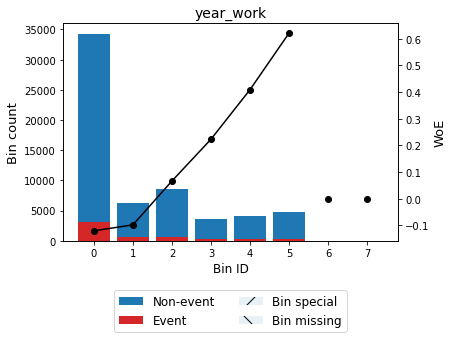

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.05)",34308,0.557826,31214,3094,0.090183,-0.120222,0.008480,0.001059
1,"[4.05, 5.61)",6247,0.101572,5695,552,0.088362,-0.097828,0.001013,0.000127
2,"[5.61, 8.80)",8528,0.138660,7880,648,0.075985,0.066569,0.000598,0.000075
3,"[8.80, 10.90)",3531,0.057412,3299,232,0.065704,0.223014,0.002601,0.000325
4,"[10.90, 14.92)",4168,0.067769,3938,230,0.055182,0.408725,0.009552,0.001186
5,"[14.92, inf)",4721,0.076760,4508,213,0.045118,0.620693,0.022887,0.002816
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,61503,1.000000,56534,4969,0.080793,,0.045131,0.005587


['(-inf, 4.05)',
 '[4.05, 5.61)',
 '[5.61, 8.80)',
 '[8.80, 10.90)',
 '[10.90, 14.92)',
 '[14.92, inf)',
 'Special',
 'Missing',
 '']

==


,column,IV,predictiveness
14,EXT_SCORE_3,0.351570,Strong predictive Power
13,EXT_SCORE_2,0.319735,Strong predictive Power
12,EXT_SCORE_1,0.190283,Medium predictive Power
25,year_age,0.104809,Medium predictive Power
11,ORGANIZATION_TYPE,0.087203,Weak predictive Power
17,Approved,0.070149,Weak predictive Power
5,INCOME_TYPE,0.068243,Weak predictive Power
18,Refused,0.063574,Weak predictive Power
6,EDUCATION,0.058582,Weak predictive Power
10,DAYS_ID_CHANGE,0.048173,Weak predictive Power


In [91]:
binning_process_full = create_binning(engineered_train, bfp,plot=True)
get_iv(binning_process_full)

In [92]:
xtrainfull = binning_process_full.transform(engineered_train)
X_test=binning_process_full.transform(engineered_test)

In [93]:
class_weight_full = get_class_weight(df)
class_weight_full

{0: 0.08079280685495016, 1: 0.9192071931450498}

In [94]:
lrfull = LogisticRegression( n_jobs=-1,
                        class_weight=class_weight_full
                       )
lrfull.fit(xtrainfull, engineered_train.TARGET)
# lr.coef_

LogisticRegression(class_weight={0: 0.08079280685495016, 1: 0.9192071931450498},
                   n_jobs=-1)

In [95]:

ytrainfullproba=lrfull.predict_proba(xtrainfull)[:,1]
ytrainfullpred=lrfull.predict(xtrainfull)

# Full Training data

precision=0.5630454929244582
recall=0.6906919835801155
fscore=0.5343691636026587


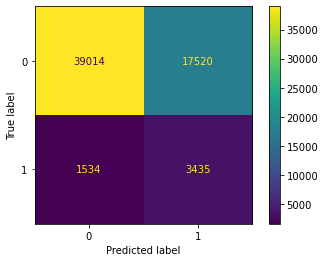

In [96]:
precision, recall, fscore, support = precision_recall_fscore_support(engineered_train.TARGET, ytrainfullpred, average='macro')
print(f"""{precision=}
{recall=}
{fscore=}""")
ConfusionMatrixDisplay.from_predictions(engineered_train.TARGET,ytrainfullpred)

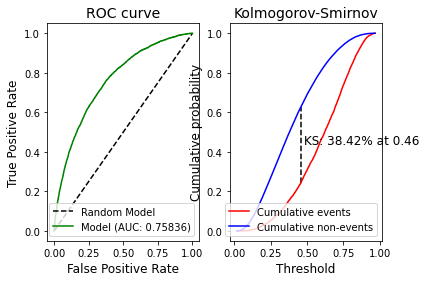

In [98]:
plt.subplot(1, 2, 1)
plot_auc_roc(engineered_train.TARGET, ytrainfullproba)
plt.subplot(1, 2, 2)
plot_ks(engineered_train.TARGET, ytrainfullproba)

# Full Testing data

In [99]:
ytestfullproba=lrfull.predict_proba(X_test)[:,1]
ytestfullpred=lrfull.predict(X_test)


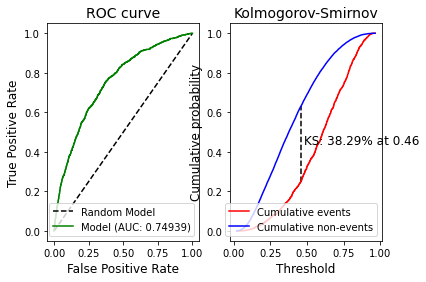

In [100]:
plt.subplot(1, 2, 1)
plot_auc_roc(engineered_test.TARGET, ytestfullproba)
plt.subplot(1, 2, 2)
plot_ks(engineered_test.TARGET, ytestfullproba)

precision=0.5610539740647529
recall=0.6830988553595114
fscore=0.5320555796897449


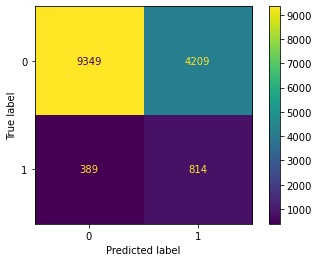

In [102]:
precision, recall, fscore, support = precision_recall_fscore_support(engineered_test.TARGET, ytestfullpred, average='macro')
print(f"""{precision=}
{recall=}
{fscore=}""")
ConfusionMatrixDisplay.from_estimator(lrfull,X_test,engineered_test.TARGET)

In [103]:
submission=dftest[['LN_ID']]
submission['TARGET']=ytestfullpred
submission['PROBA']=ytestfullproba

C:\Users\mrlut\AppData\Local\Temp/ipykernel_14952/3602346020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['TARGET']=ytestfullpred
C:\Users\mrlut\AppData\Local\Temp/ipykernel_14952/3602346020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['PROBA']=ytestfullproba


In [104]:
submission.to_csv('submission.csv',index=False)

In [107]:
joblib.dump(binning_process_full, 'final_binning_process_full.pkl')
joblib.dump(lrfull, 'final_model.pkl')

['final_model.pkl']